# Sensitivity Analysis

The aim of this analysis is to assess the impact of the `min_support` parameter of the L3 classifier on the explanations.

Let $X, Y$ be itemsets, $X \Rightarrow Y$ an association rule and $T$ a set of transactions of a given database.

**Support**
$$supp(X) = \frac{|t \in T; X \in t|}{|T|}$$
Support is an indication of how frequently the itemset appears in the dataset. Support of $X$ w.r.t. $T$ is the proportion of transctions $t$ in the dataset that containt the itemset $X$.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
plt.rc('text', usetex=True)
plt.rc('figure', figsize=[30, 10])
plt.rc('font', size=18)

In [13]:
import random
from os.path import join

import arff

from src import DEFAULT_DIR
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset


def load_arff(f) -> Dataset:
    a = arff.load(f)
    dataset = Dataset(a['data'], a['attributes'])

    return dataset


def import_dataset_arff(f, explain_indices,
                        random_explain_dataset: bool):
    dataset = load_arff(f)

    dataset_len = len(dataset)
    train_indices = list(range(dataset_len))

    if random_explain_dataset:
        random.seed(1)
        # small dataset
        MAX_SAMPLE_COUNT = 100
        if dataset_len < (2 * MAX_SAMPLE_COUNT):
            samples = int(0.2 * dataset_len)
        else:
            samples = MAX_SAMPLE_COUNT

        # Randomly pick some instances to remove from the training dataset and use in the
        # explain dataset
        explain_indices = list(random.sample(train_indices, samples))
    for i in explain_indices:
        train_indices.remove(i)

    train_dataset = Dataset.from_indices(train_indices, dataset)
    explain_dataset = Dataset.from_indices(explain_indices, dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]


def import_datasets_arff(f, f_explain, explain_indices,
                         random_explain_dataset: bool):
    train_dataset = load_arff(f)
    explain_dataset = load_arff(f_explain)

    len_explain_dataset = len(explain_dataset)

    if random_explain_dataset:
        random.seed(7)
        explain_indices = list(random.sample(range(len_explain_dataset), 300))
        explain_dataset = Dataset.from_indices(explain_indices, explain_dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]


def get_classifier(classifier_name: str):
    if classifier_name == "sklearn_nb":
        from sklearn.naive_bayes import CategoricalNB

        skl_clf = CategoricalNB()

        return skl_clf

    if classifier_name == "sklearn_rf":
        from sklearn.ensemble import RandomForestClassifier

        skl_clf = RandomForestClassifier(random_state=42)

        return skl_clf

    if classifier_name == "nn_onehot_enc":
        from sklearn.neural_network import MLPClassifier
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import OneHotEncoder

        pipe = make_pipeline(OneHotEncoder(), MLPClassifier(random_state=42, max_iter=1000))
        skl_clf = pipe

        return skl_clf

    raise ValueError("Classifier not available")


def get_explanation(ix, dataset_name: str, classifier_name: str, min_sup):
    explain_dataset_indices = []
    if dataset_name in [join(DEFAULT_DIR, "datasets/adult_d.arff"),
                        join(DEFAULT_DIR, "datasets/compas-scores-two-years_d.arff")]:
        with open(dataset_name) as f, open(dataset_name[:-5] + "_explain.arff") as f_explain:
            train_dataset, explain_dataset, explain_indices = import_datasets_arff(f, f_explain,
                                                                                   explain_dataset_indices,
                                                                                   True)
    else:
        with open(dataset_name) as f:
            train_dataset, explain_dataset, explain_indices = import_dataset_arff(
                f, explain_dataset_indices, True)

    clf = get_classifier(classifier_name).fit(train_dataset.X_numpy(),
                                              train_dataset.Y_numpy())
    explainer = XPLAIN_explainer(clf, train_dataset, min_sup)

    decoded_instance = explain_dataset.get_decoded(ix)

    cc = explain_dataset.class_column_name()
    decoded_target_class = decoded_instance[cc]

    return explainer.explain_instance(explain_dataset[ix], decoded_target_class)


In [4]:
def plot(ax, e):
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    
    ax.set_title(
f"""Importance
$P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
    )
    ax.set_ylabel("Attribute or rule", labelpad=2)
    ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)
    
    ax.grid(True)
    
    ax.barh(
        attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

## Monks

### Categorical Naive Bayes

Instance 0
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01, 2.099E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

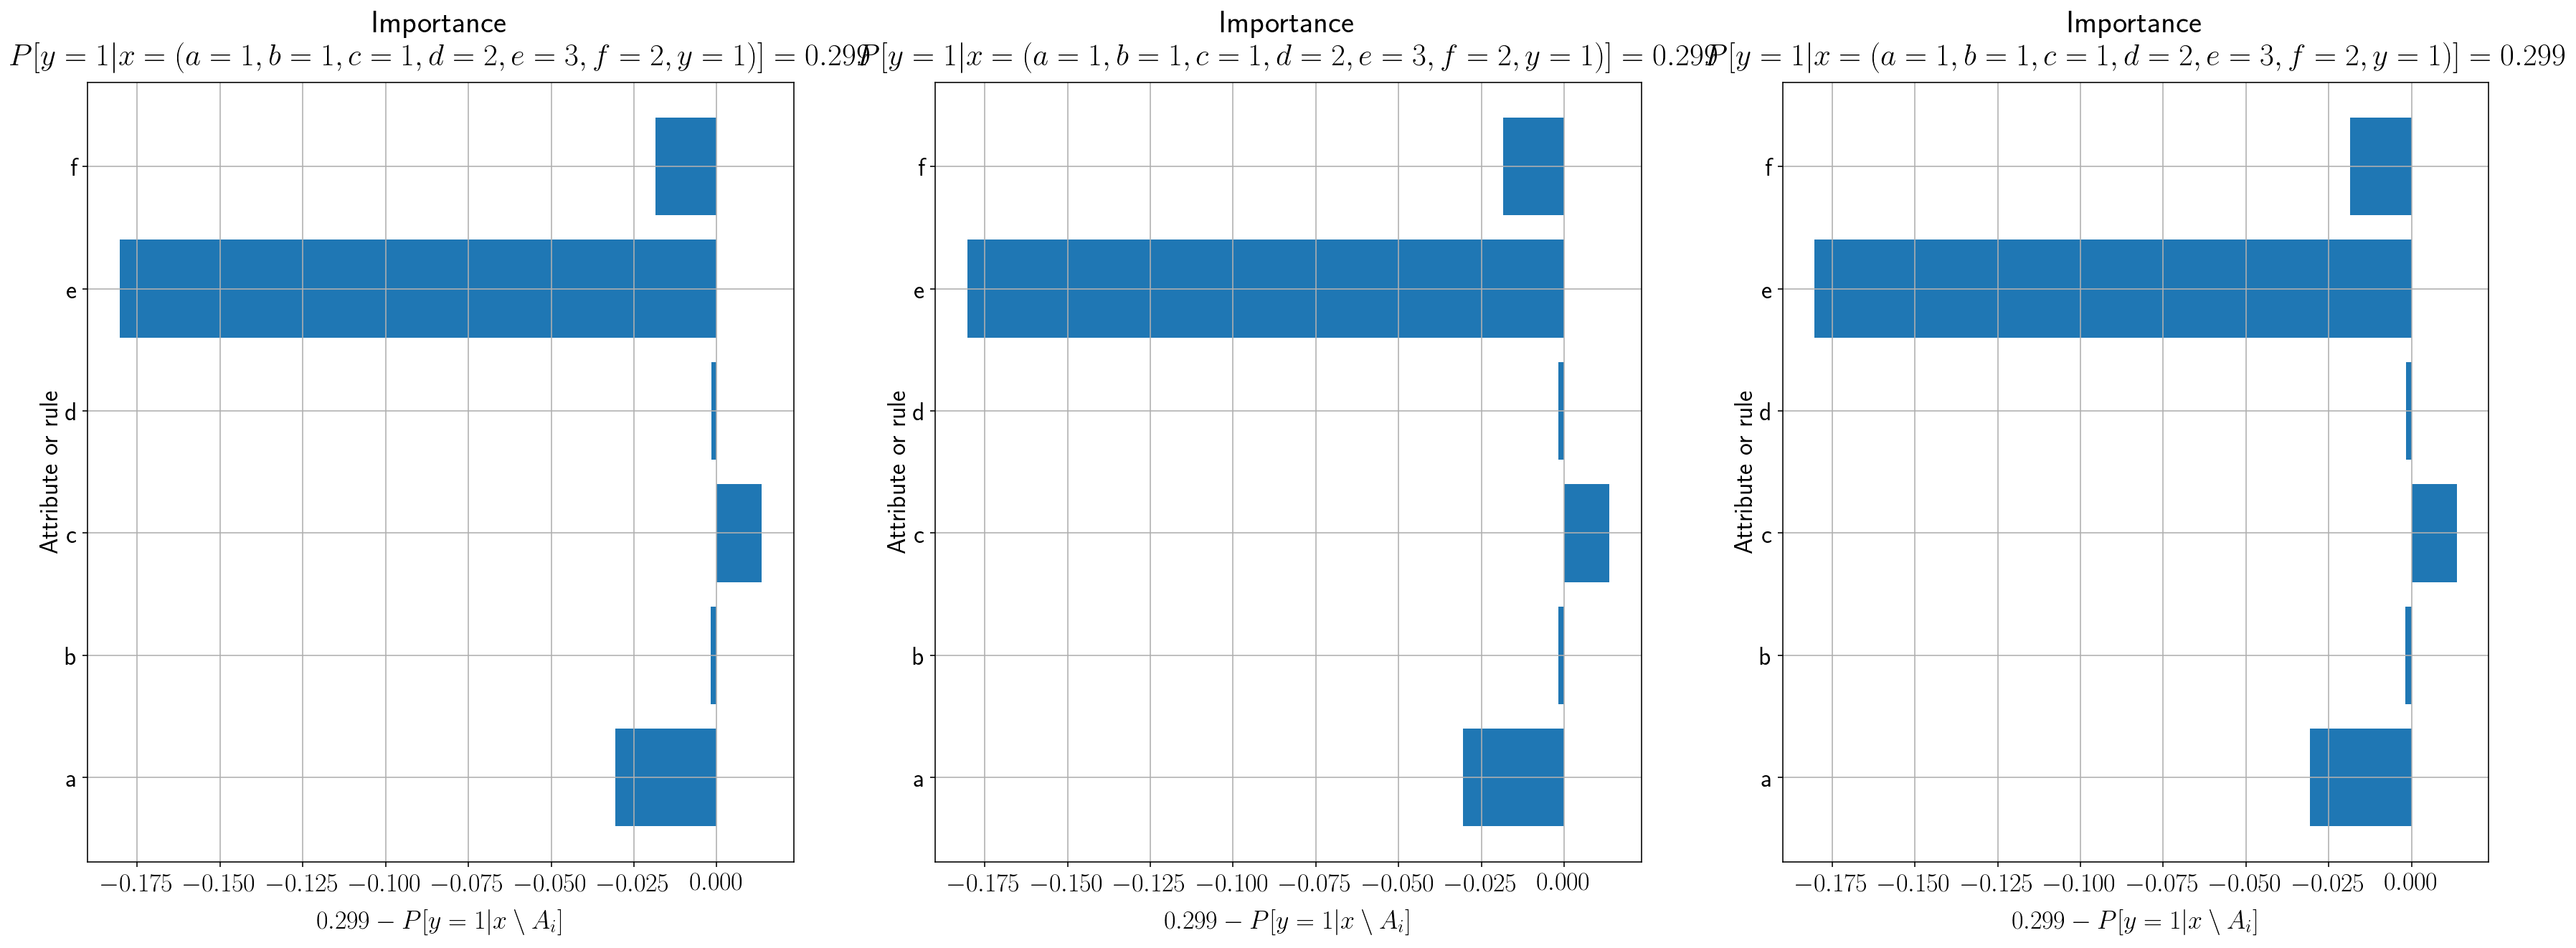

Instance 1
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

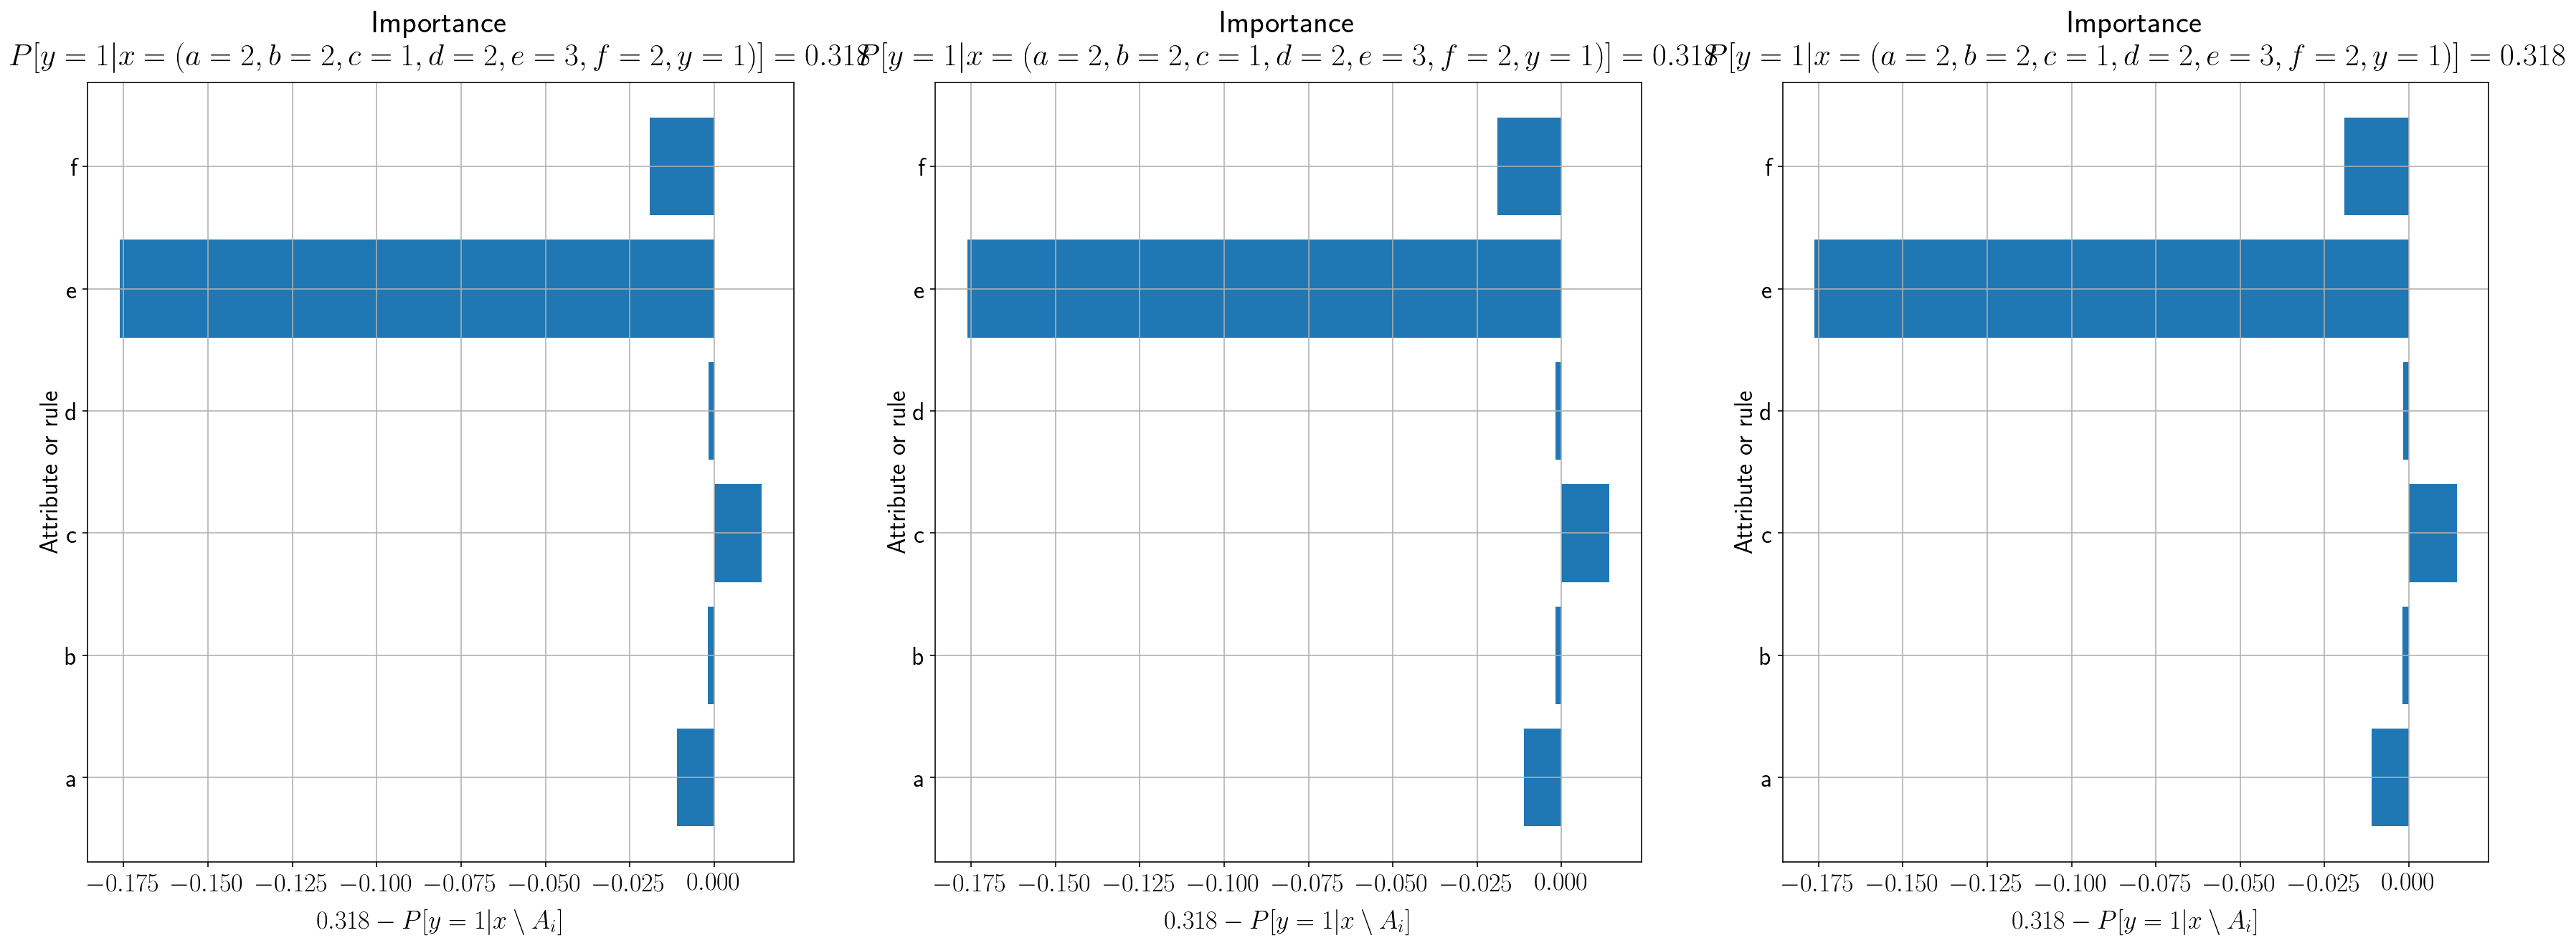

Instance 2
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02, 4.783E-02
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

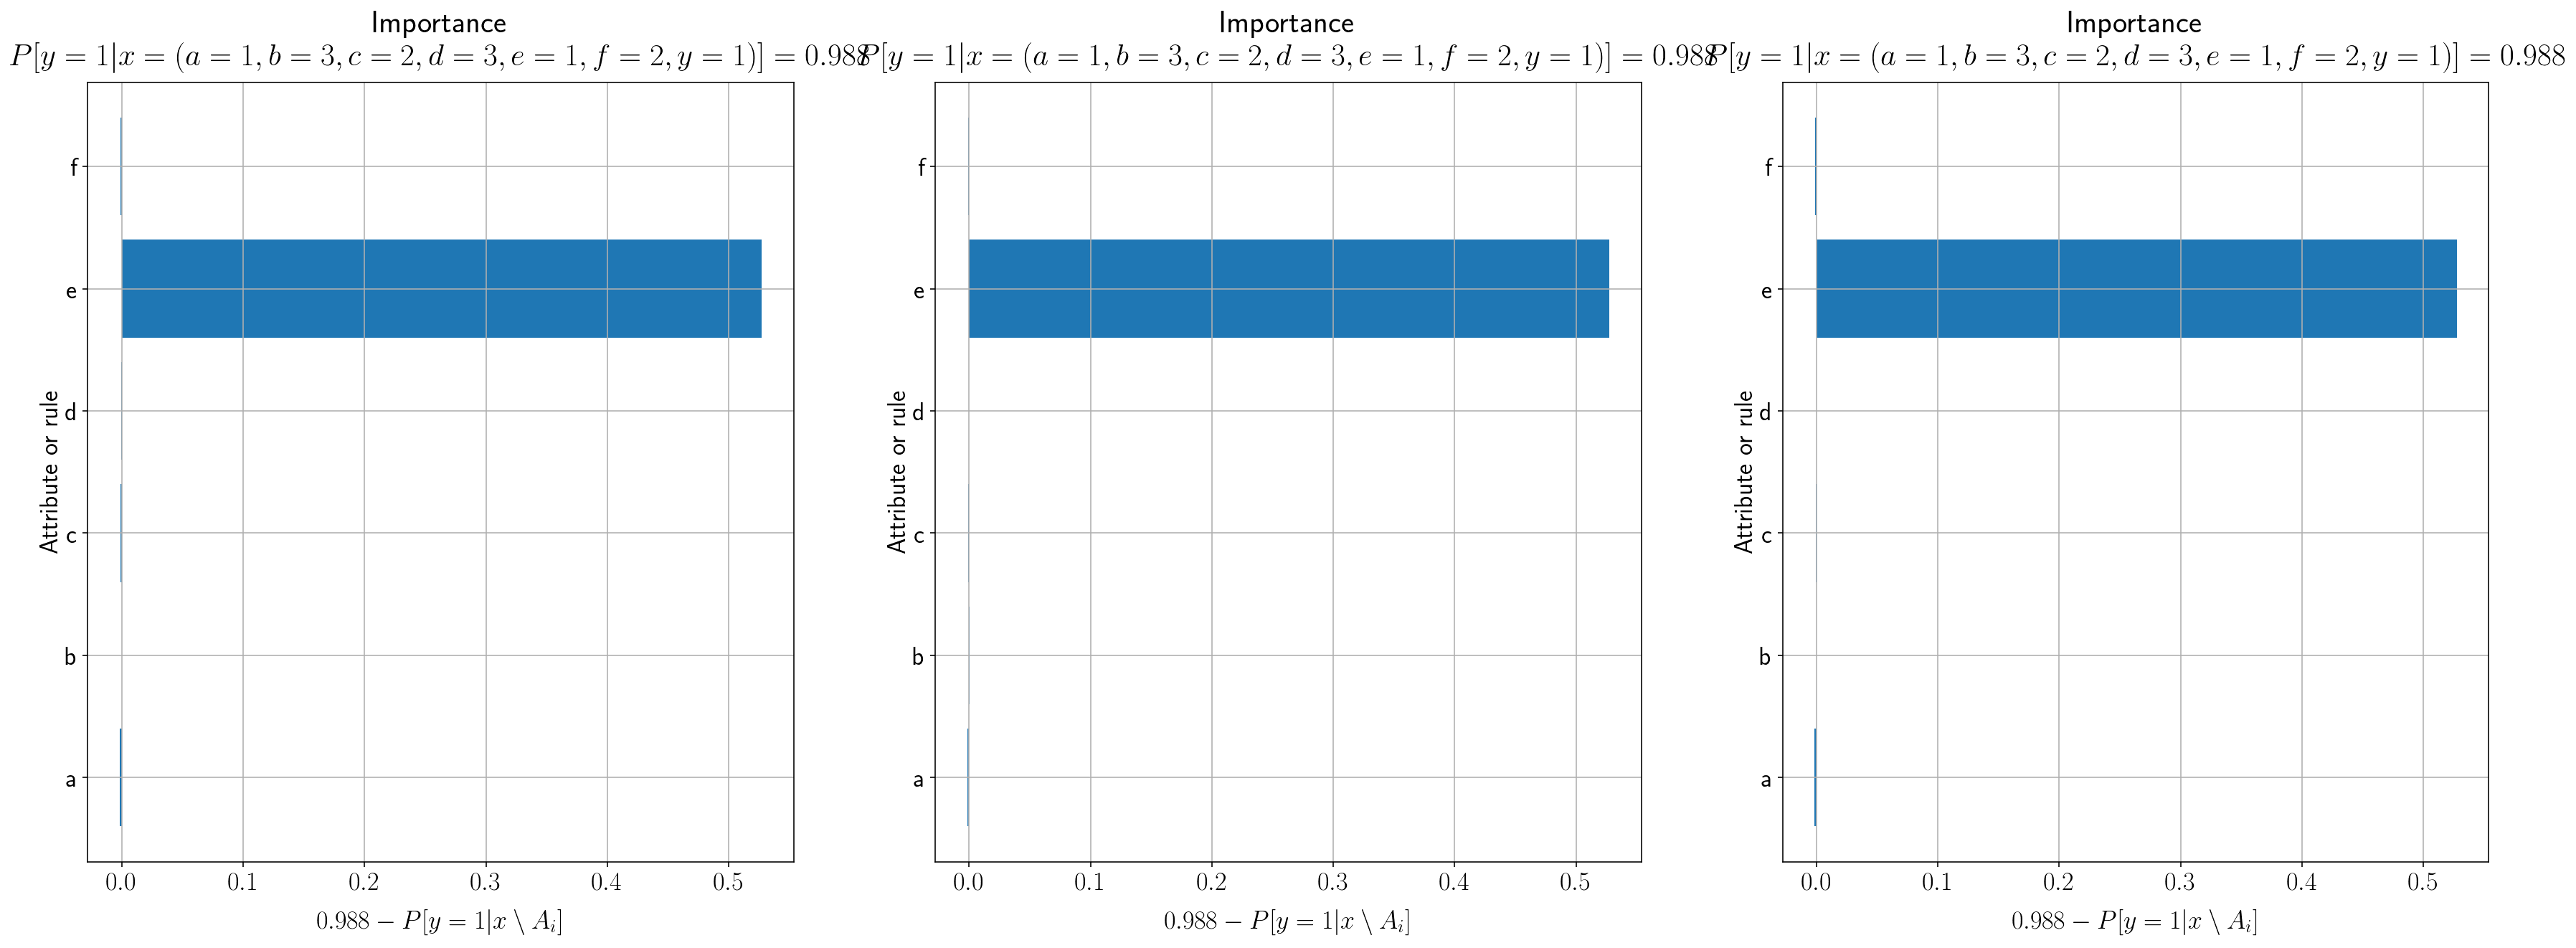

Instance 3
compute_lace_step k=21
explain_instance errors: 8.865E-03
compute_lace_step k=21
explain_instance errors: 8.865E-03
compute_lace_step k=21
explain_instance errors: 8.865E-03


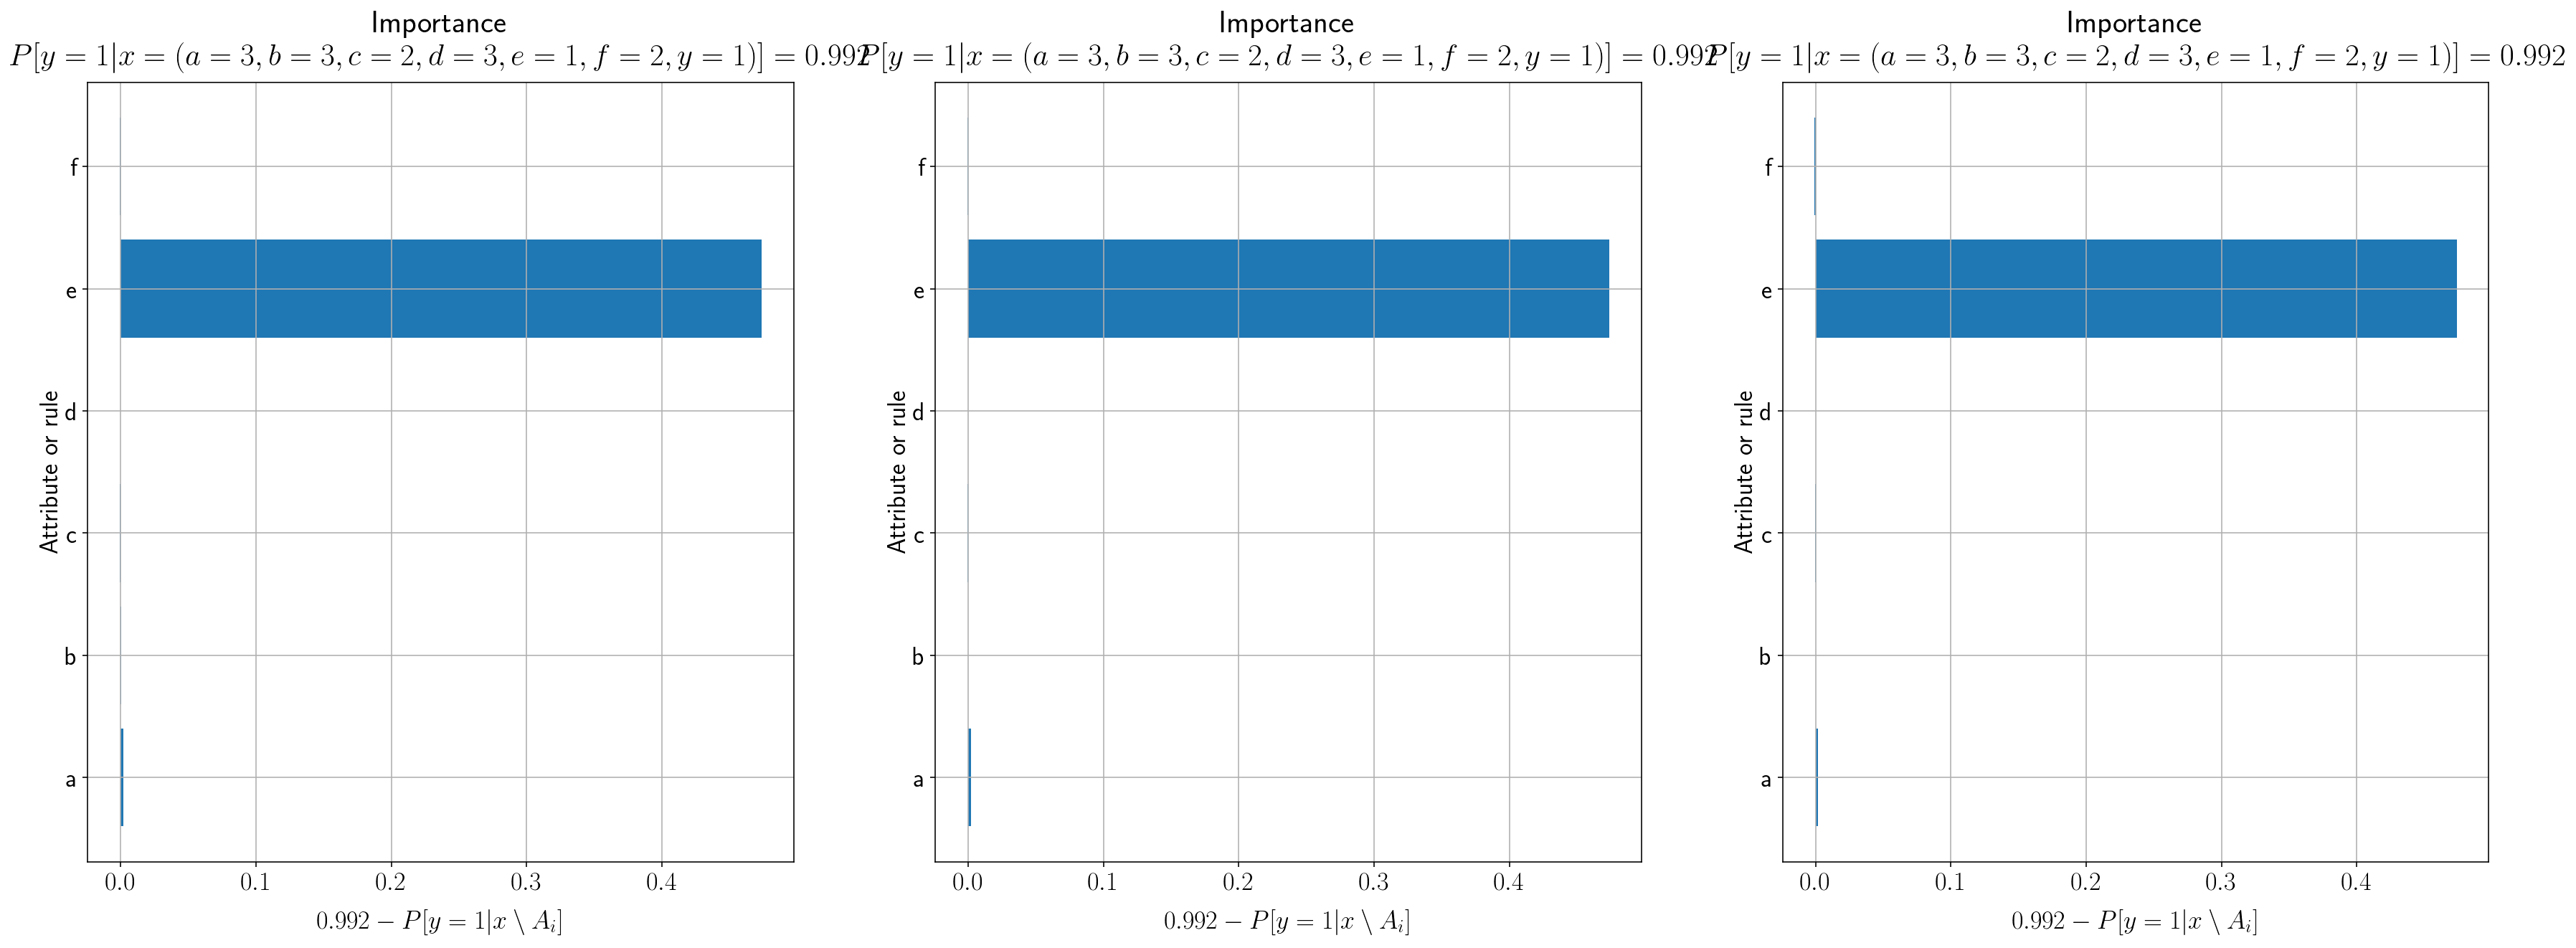

In [11]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Random Forest

Instance 0
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

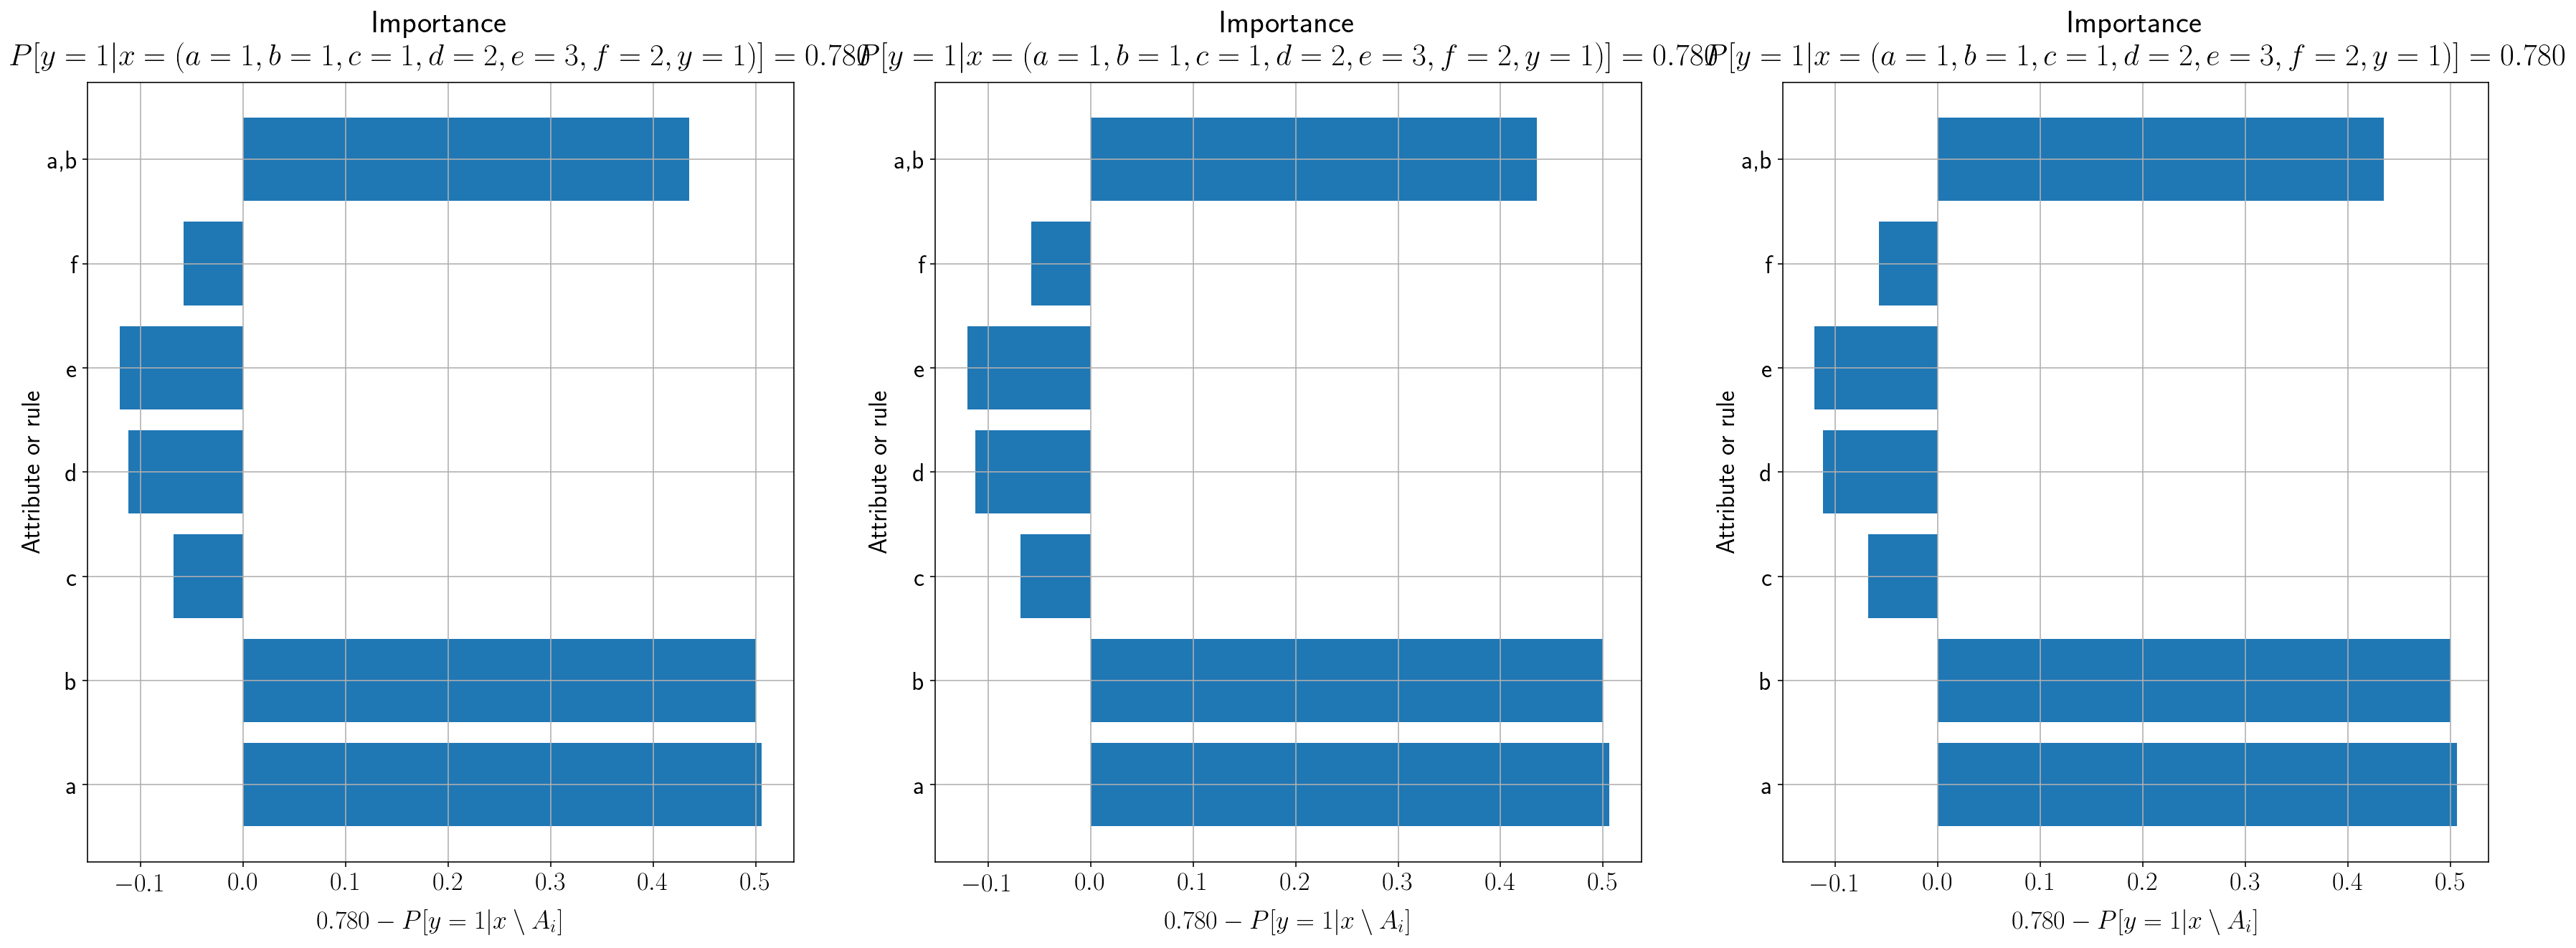

Instance 1
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01, 1.640E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

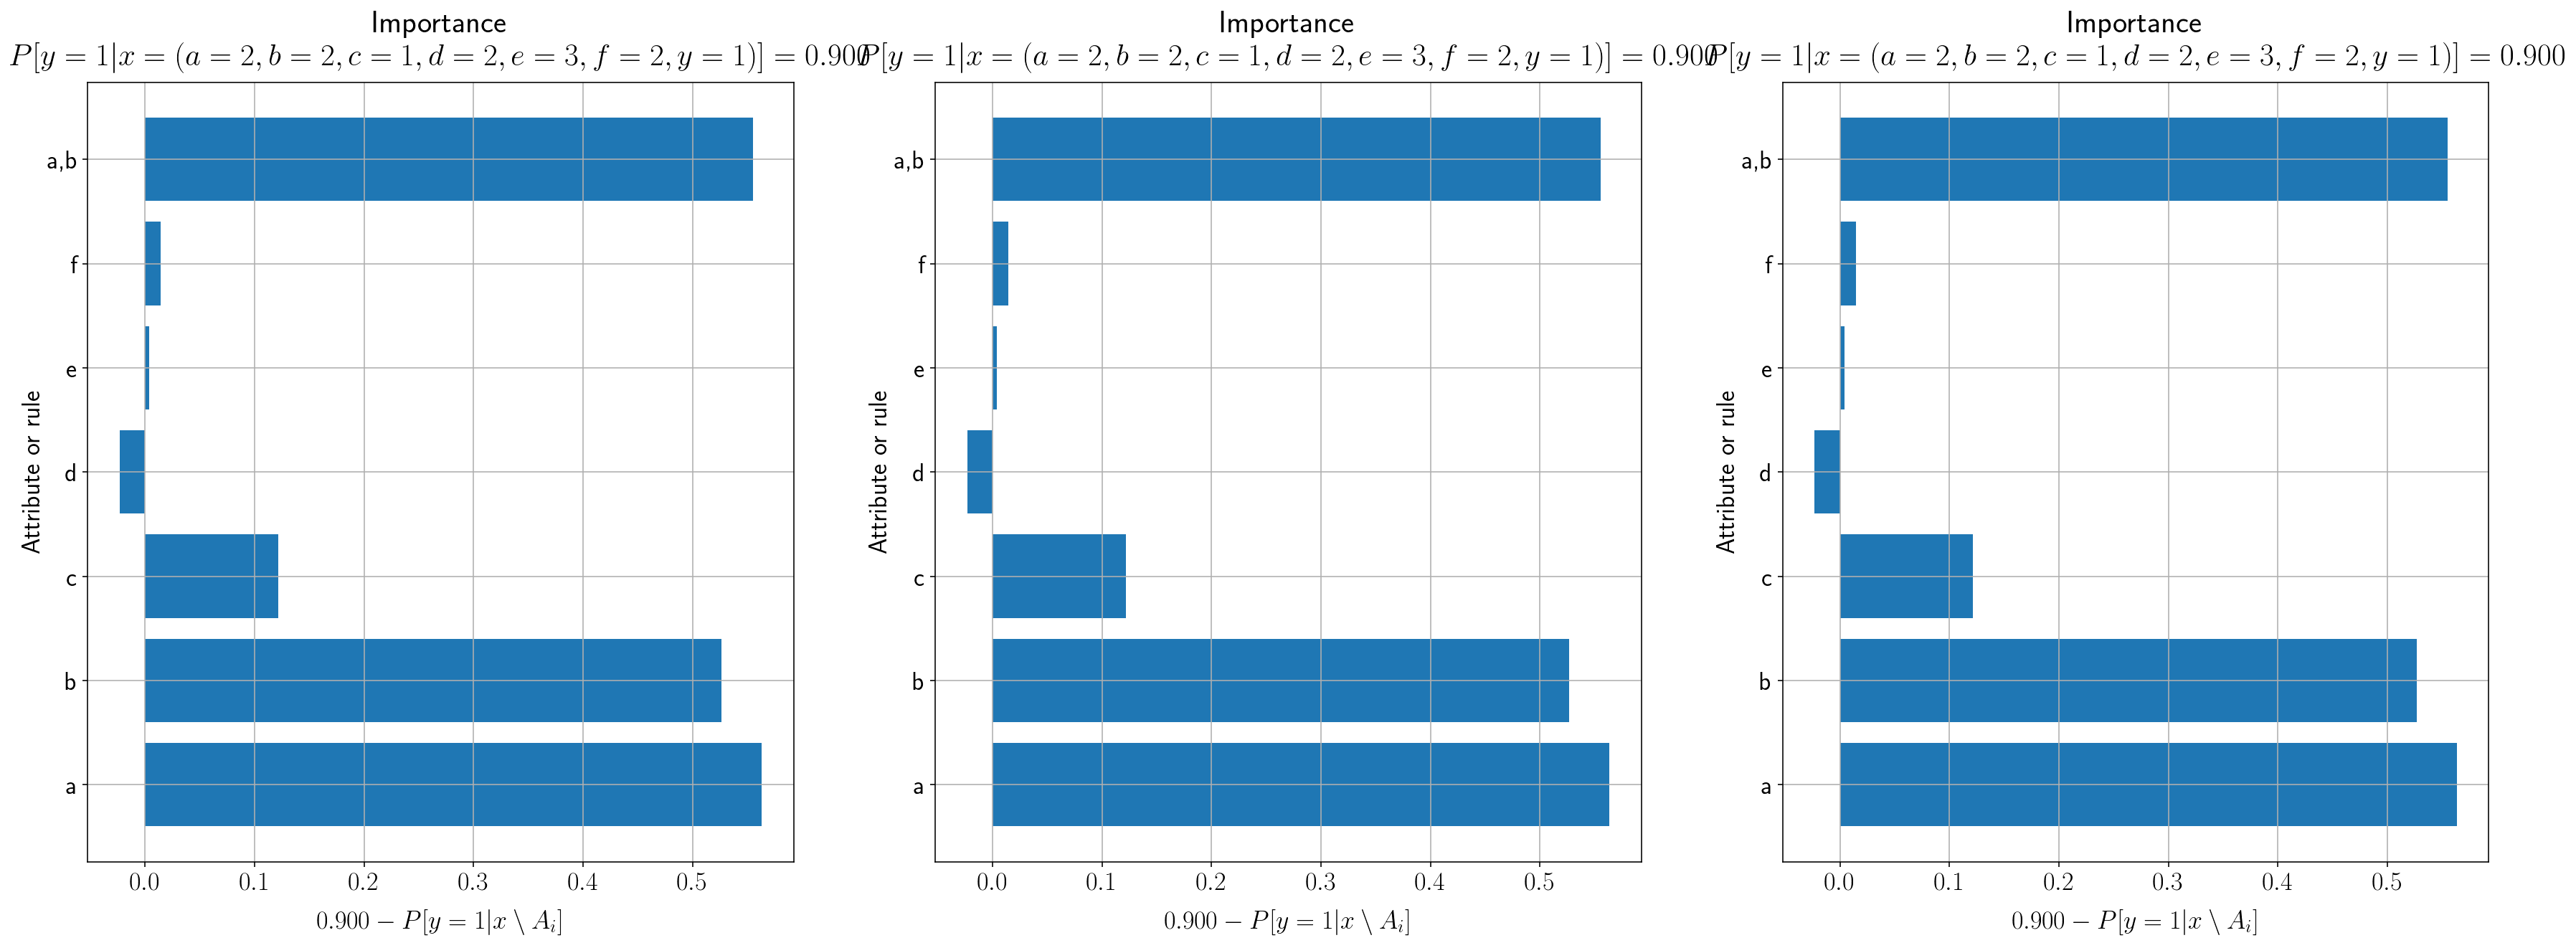

Instance 2
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01, 2.722E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

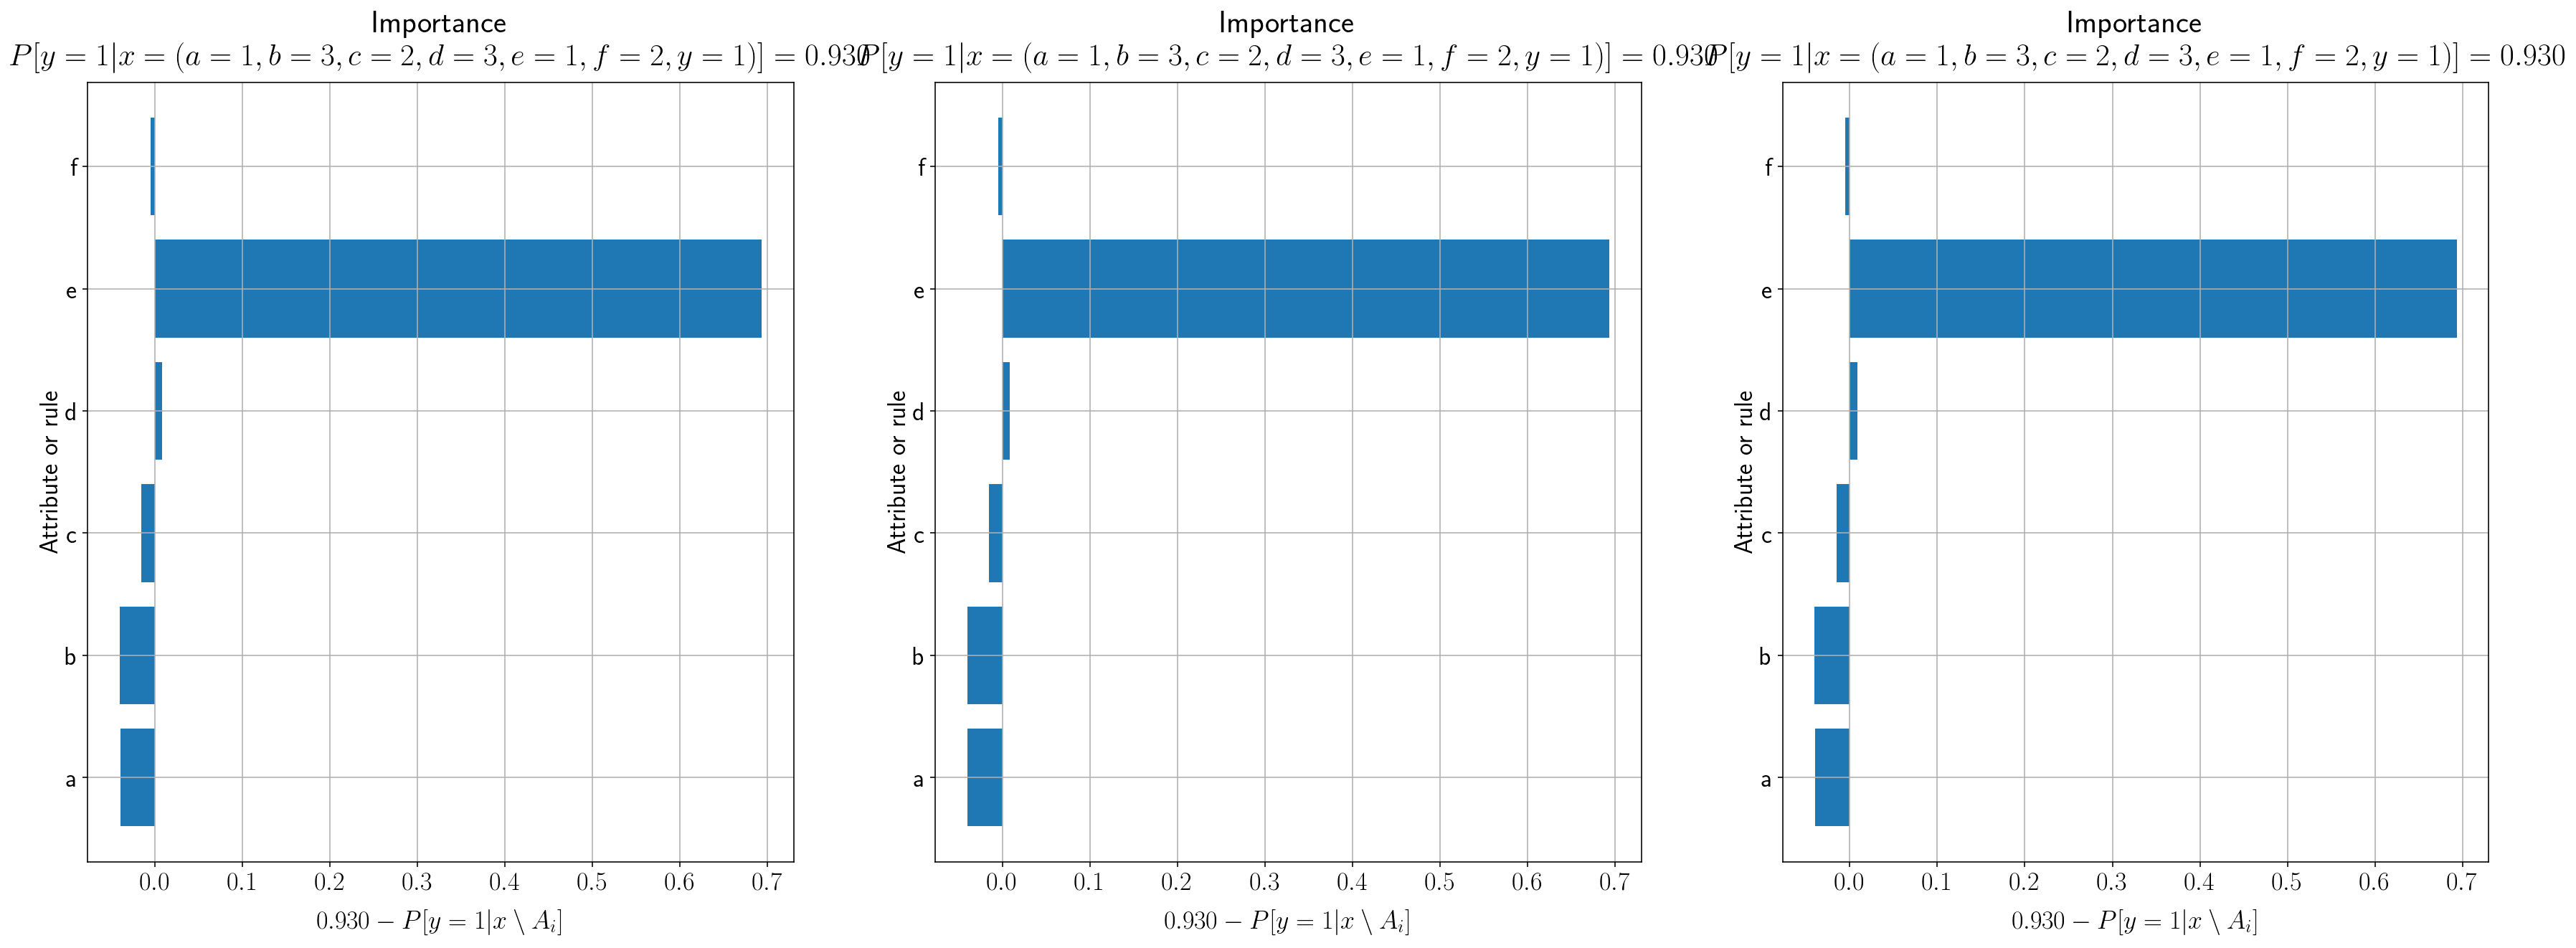

Instance 3
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.356E-01, 1.783E-02
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.356E-01, 1.783E-02
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.356E-01, 1.783E-02


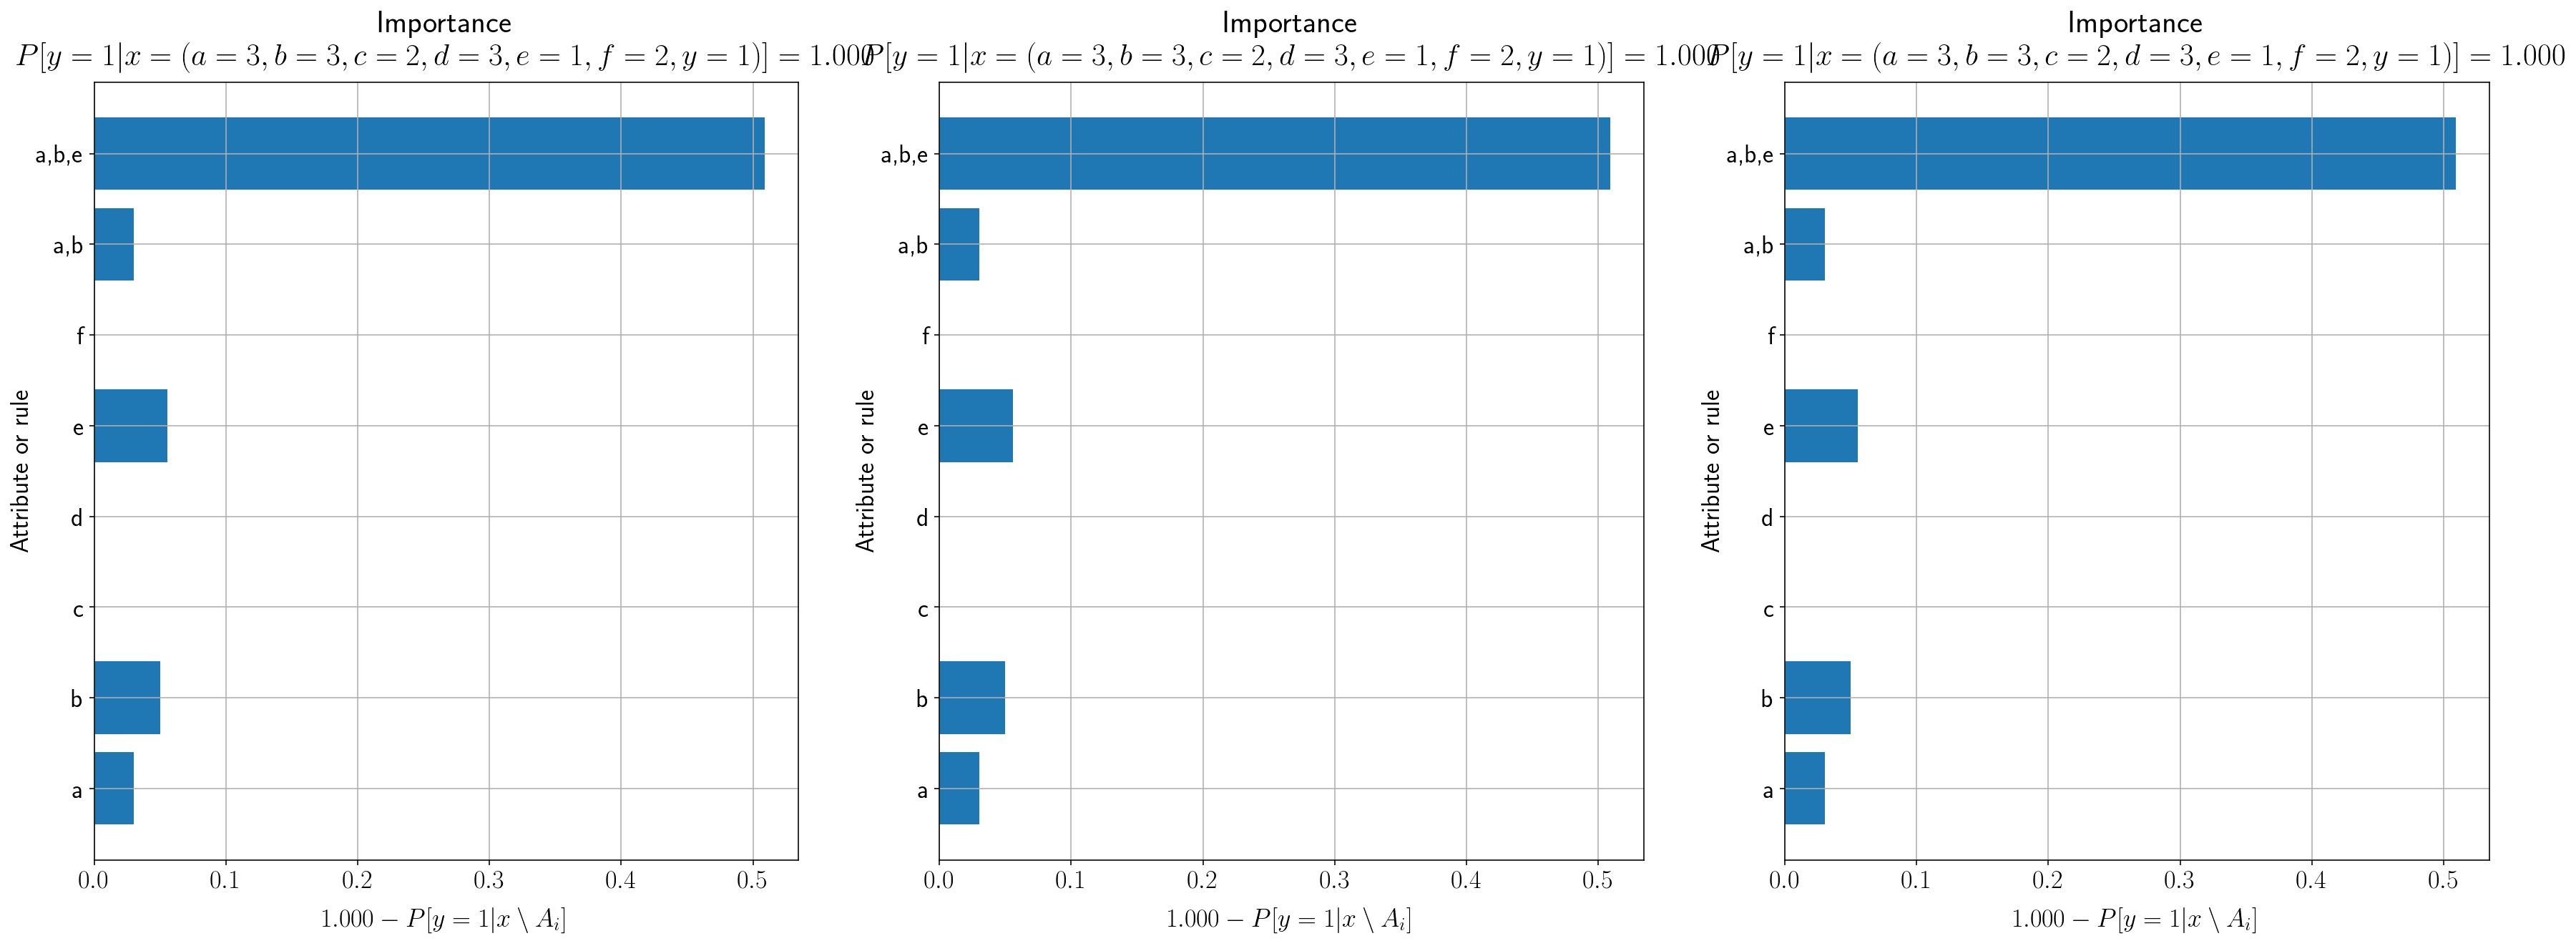

In [14]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Neural Network

Instance 0
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

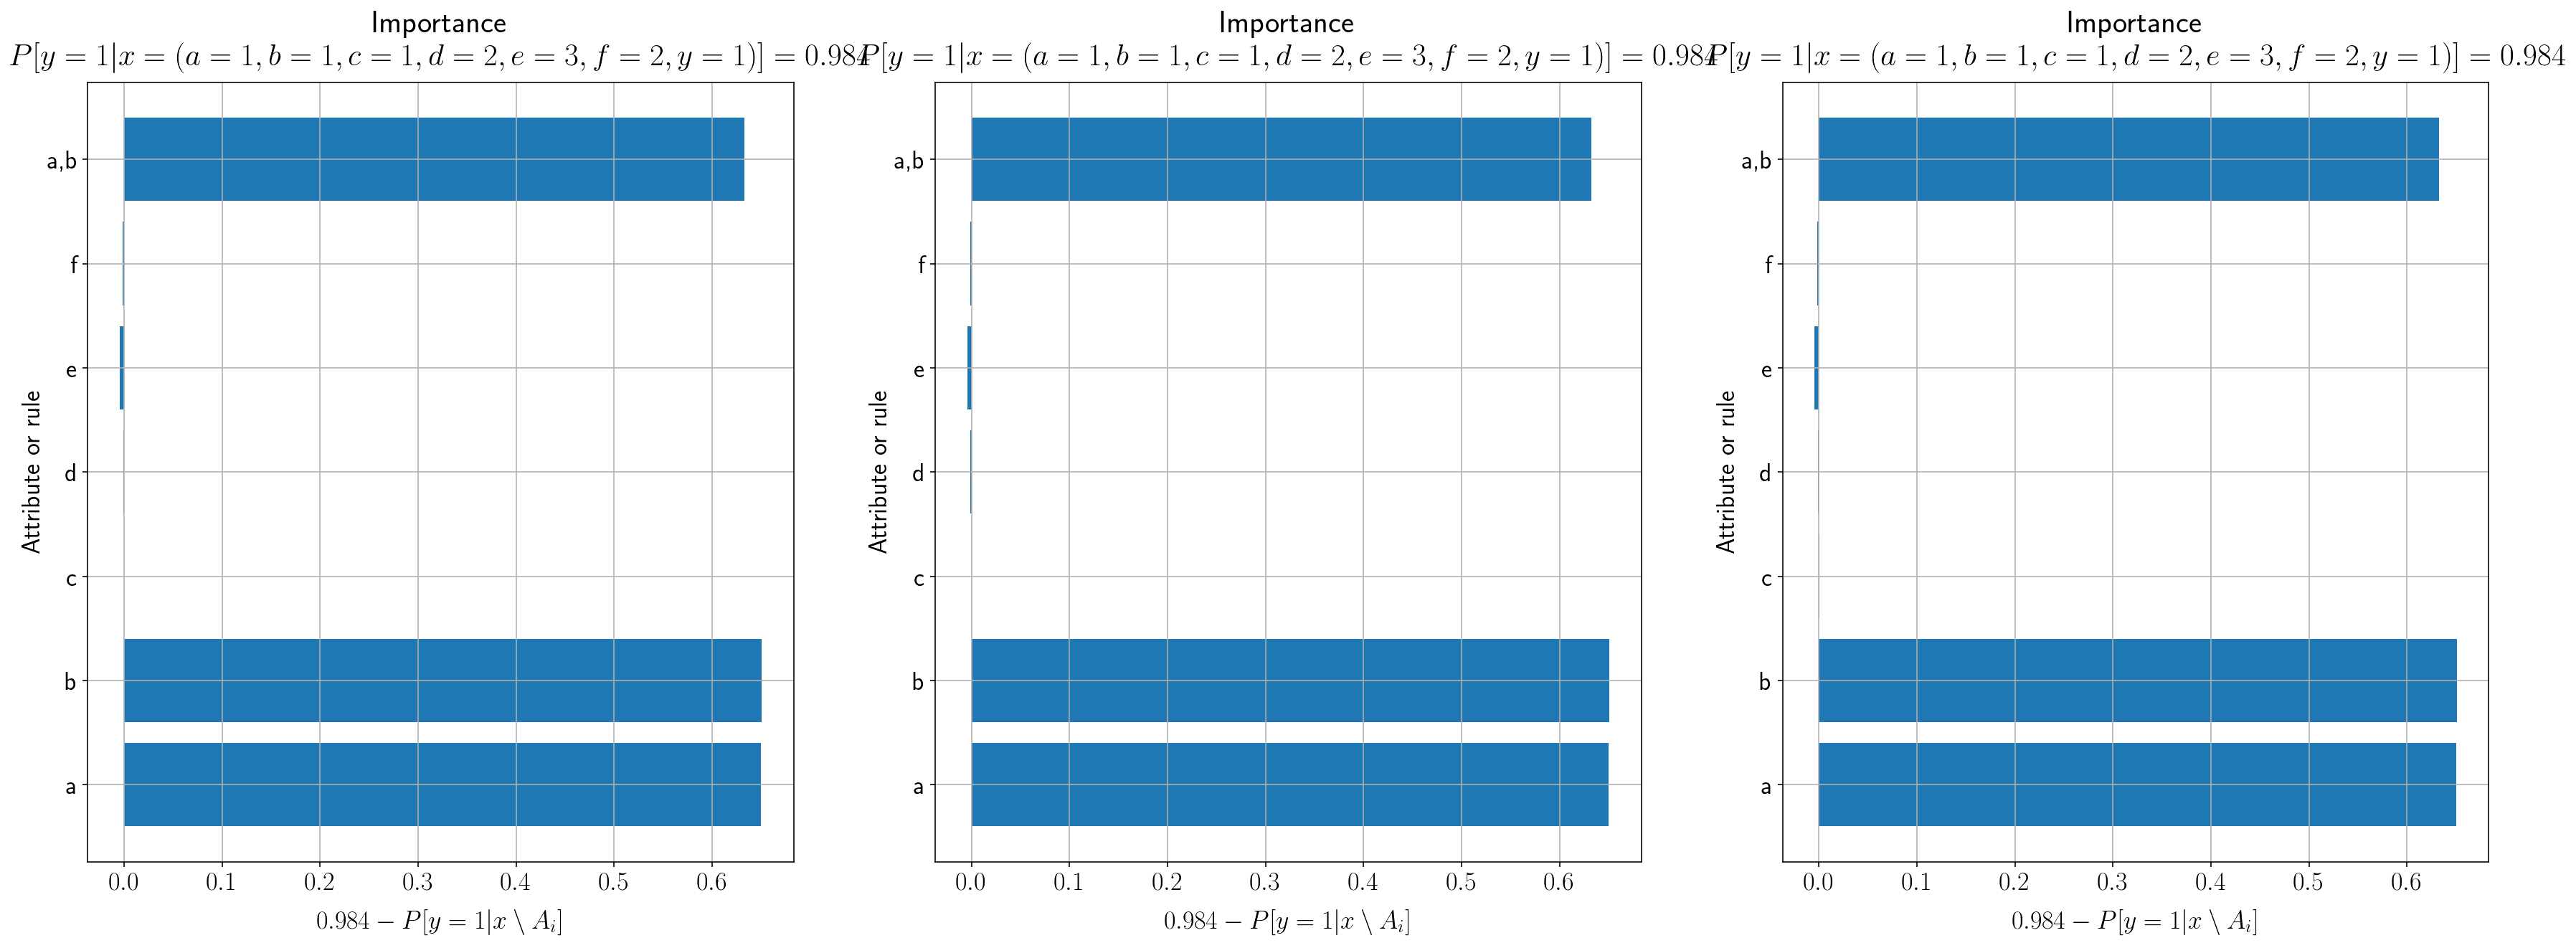

Instance 1
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01, 1.575E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

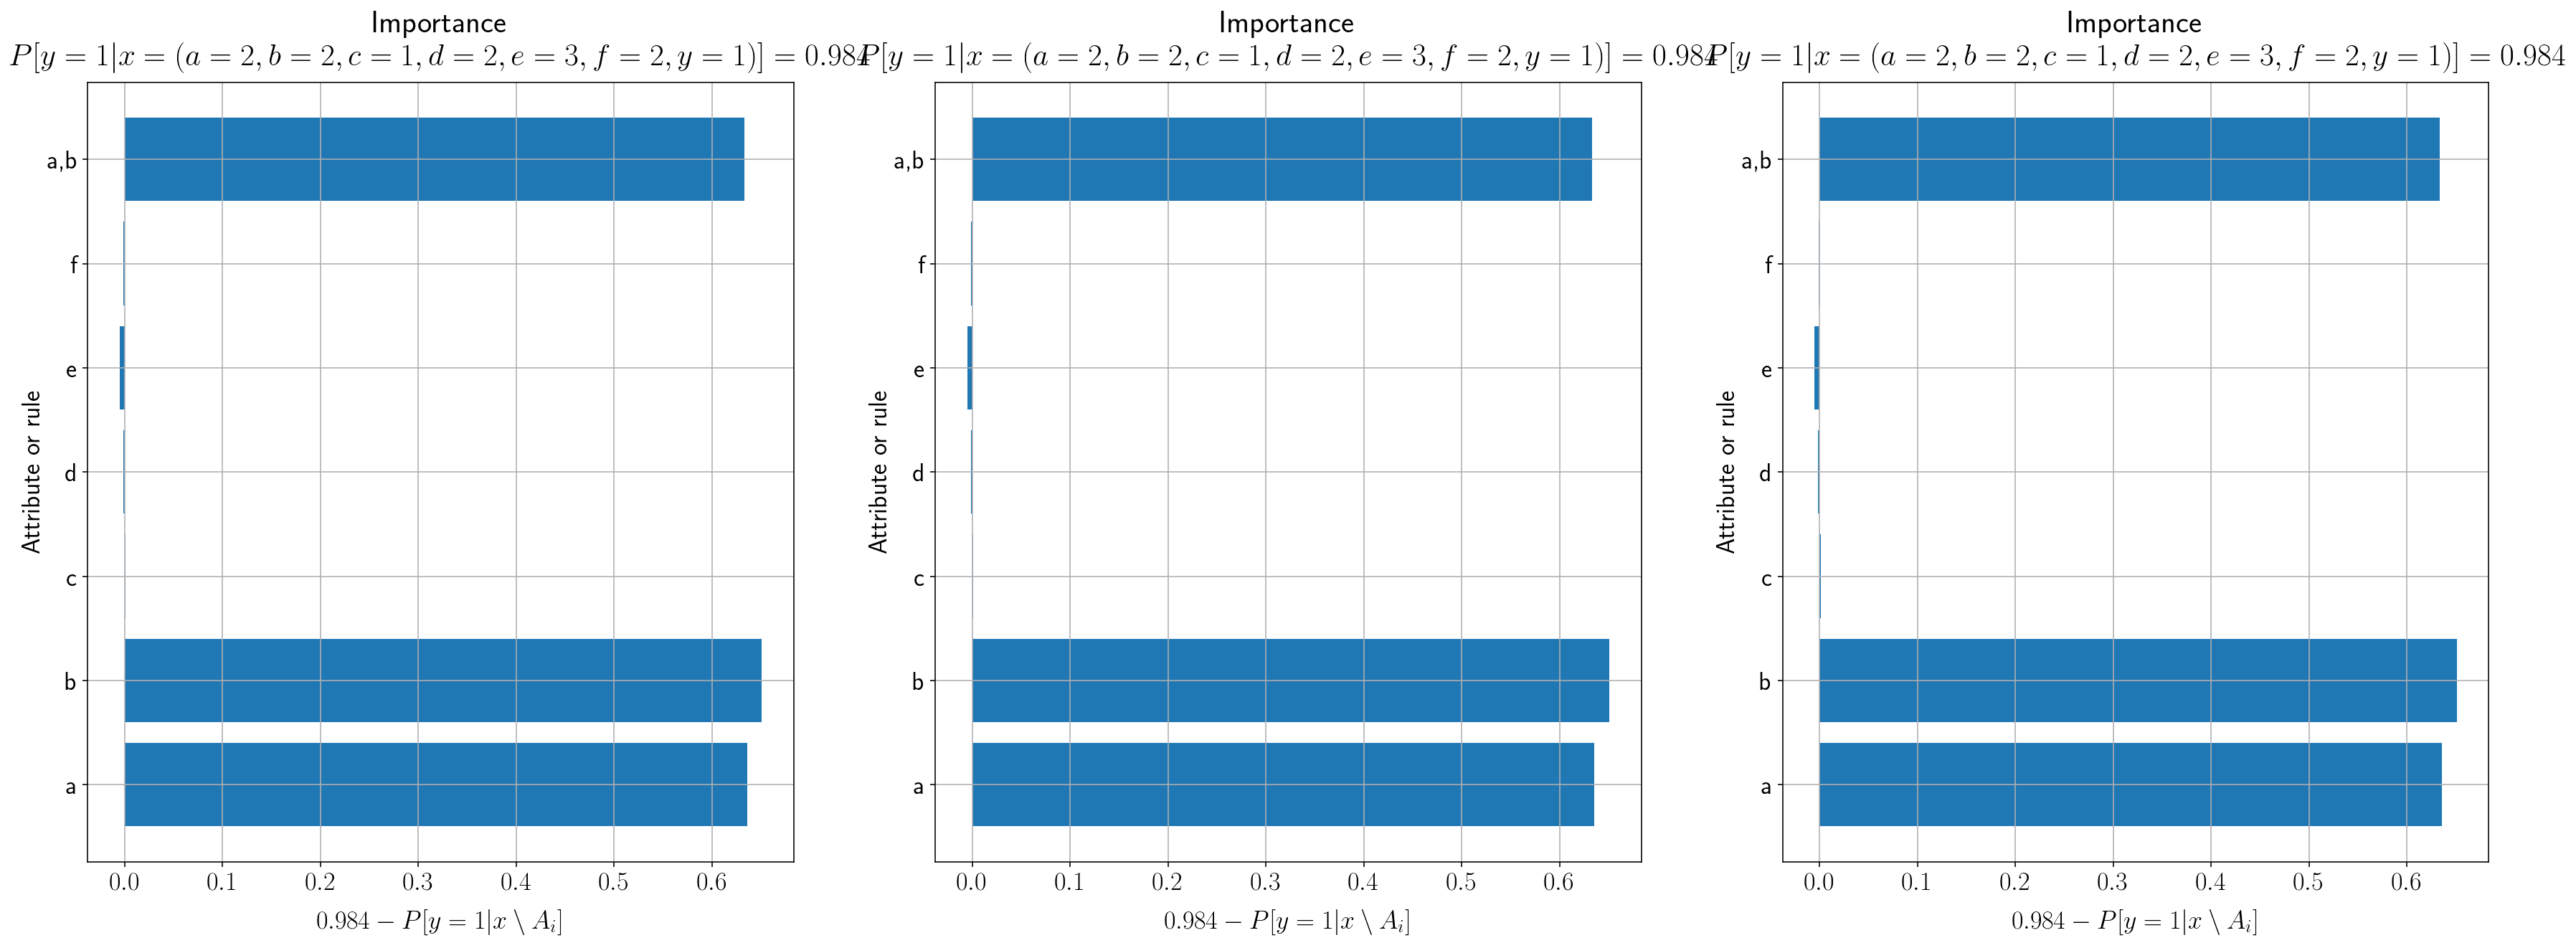

Instance 2
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_instance errors: 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01, 2.602E-01
compute_lace_step k=21
compute_lace_step k=42
compute_lace_step k=63
compute_lace_step k=84
compute_lace_step k=105
compute_lace_step k=126
compute_lace_step k=147
compute_lace_step k=168
compute_lace_step k=189
compute_lace_step k=210
explain_insta

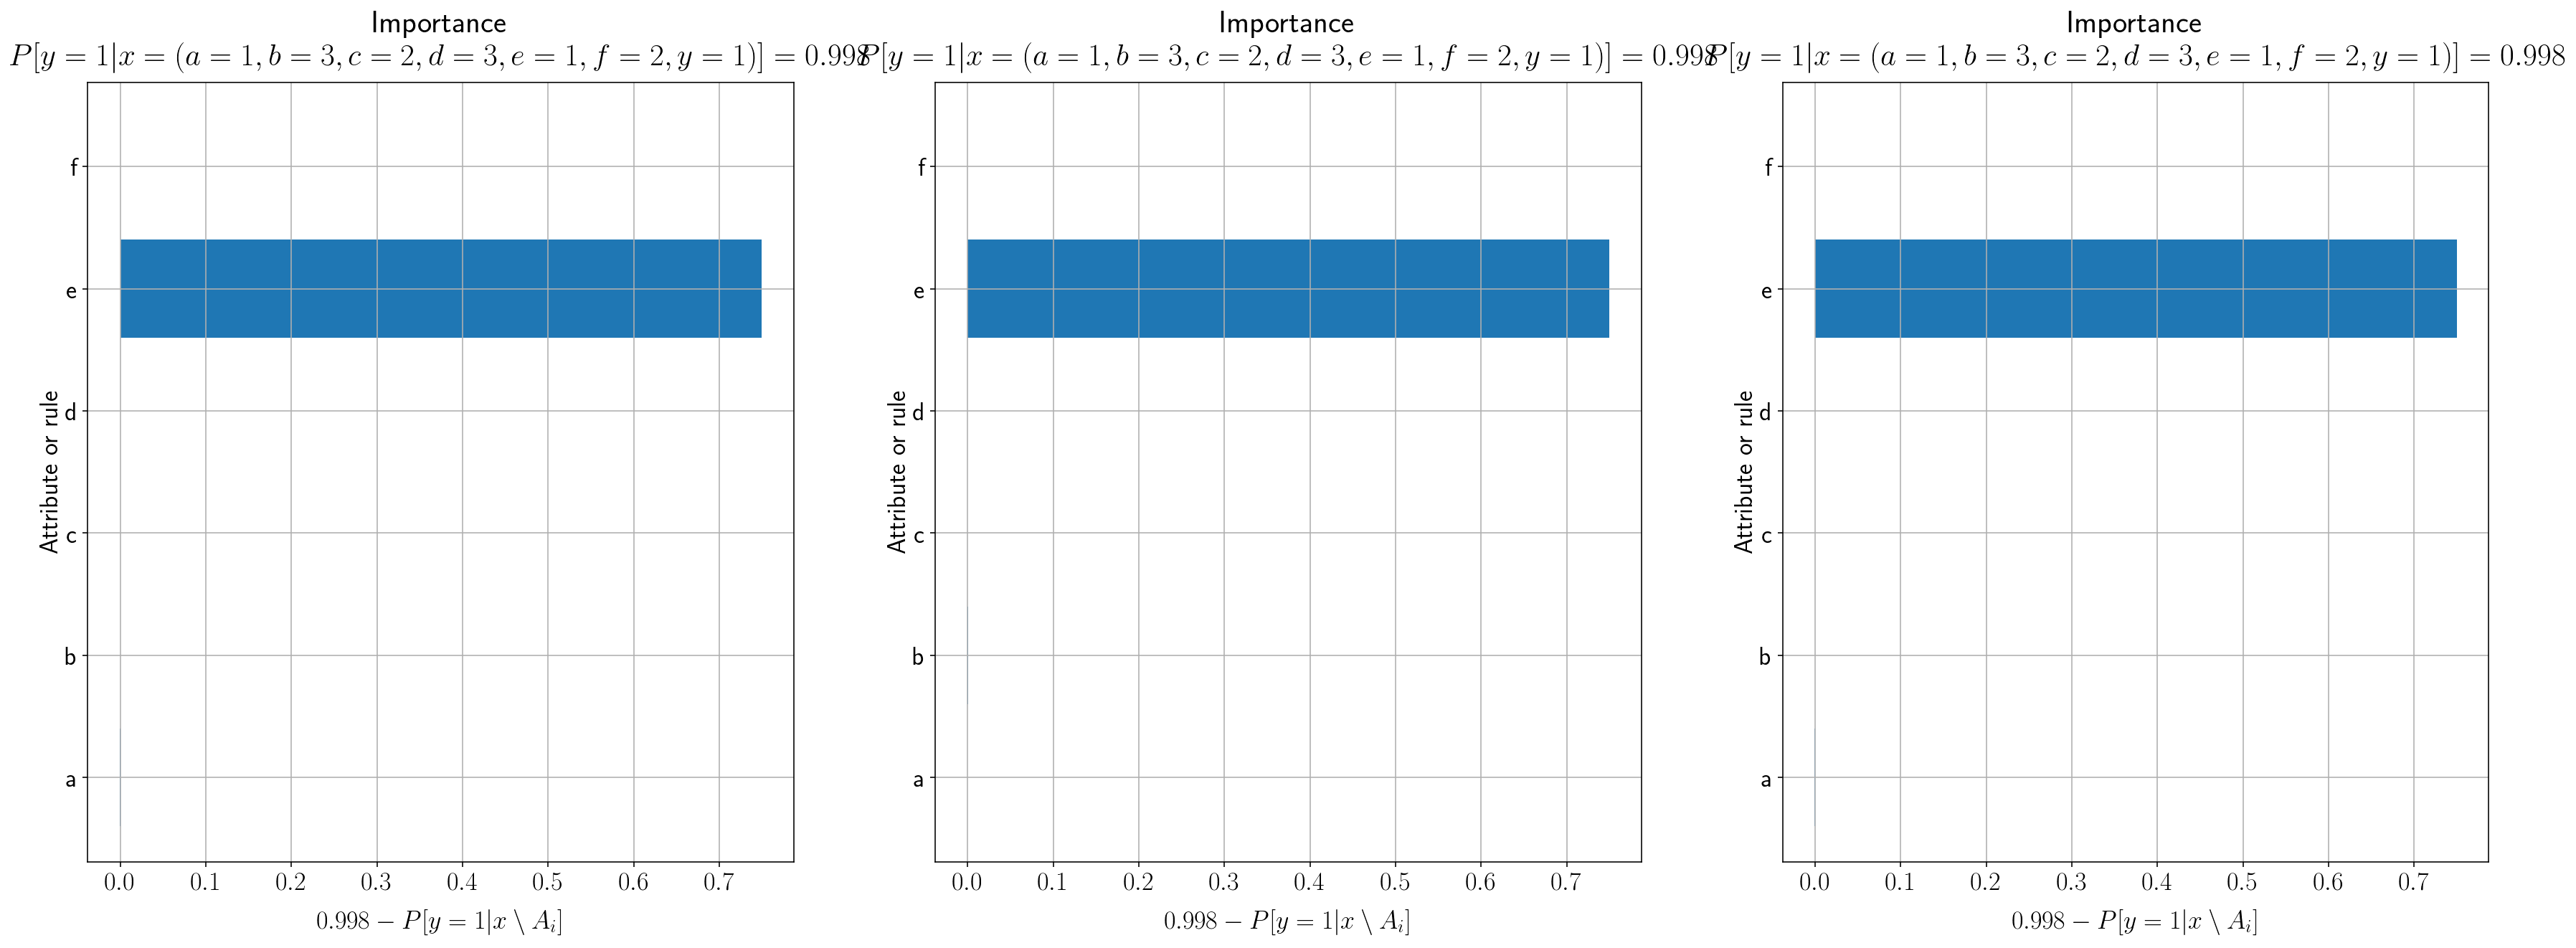

Instance 3
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.816E-01, 6.065E-04
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.816E-01, 6.065E-04
compute_lace_step k=21
compute_lace_step k=42
explain_instance errors: 4.816E-01, 6.065E-04


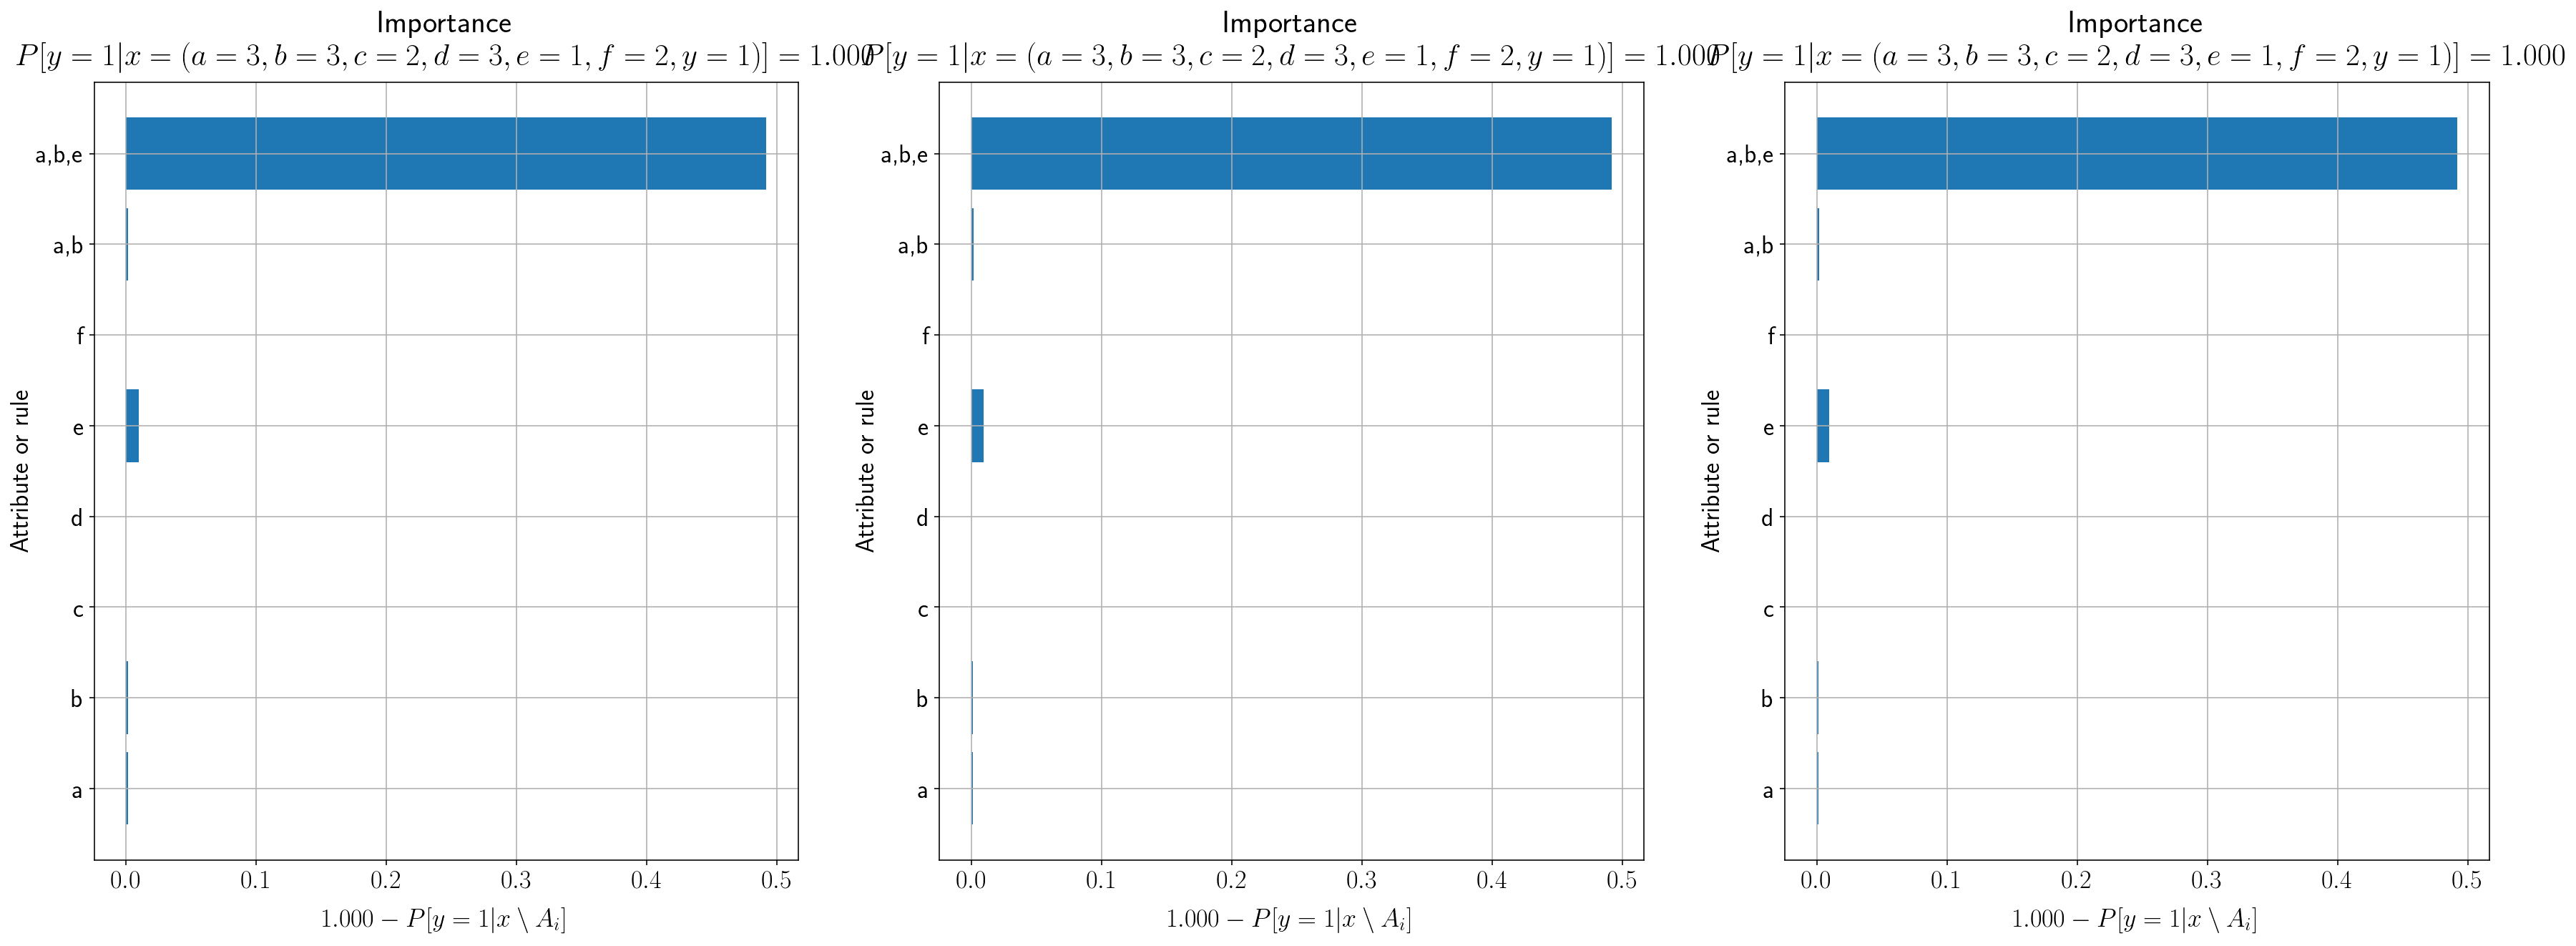

In [16]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.075))
    plt.show()

for i in range(4):
    run(i)

## Monks Extended

### Categorical Naive Bayes

Instance 0
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.225E-01, 2.225E-01, 2.225E-01, 1.188E-02
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.225E-01, 2.225E-01, 2.225E-01, 1.188E-02
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.225E-01, 2.225E-01, 2.225E-01, 1.188E-02


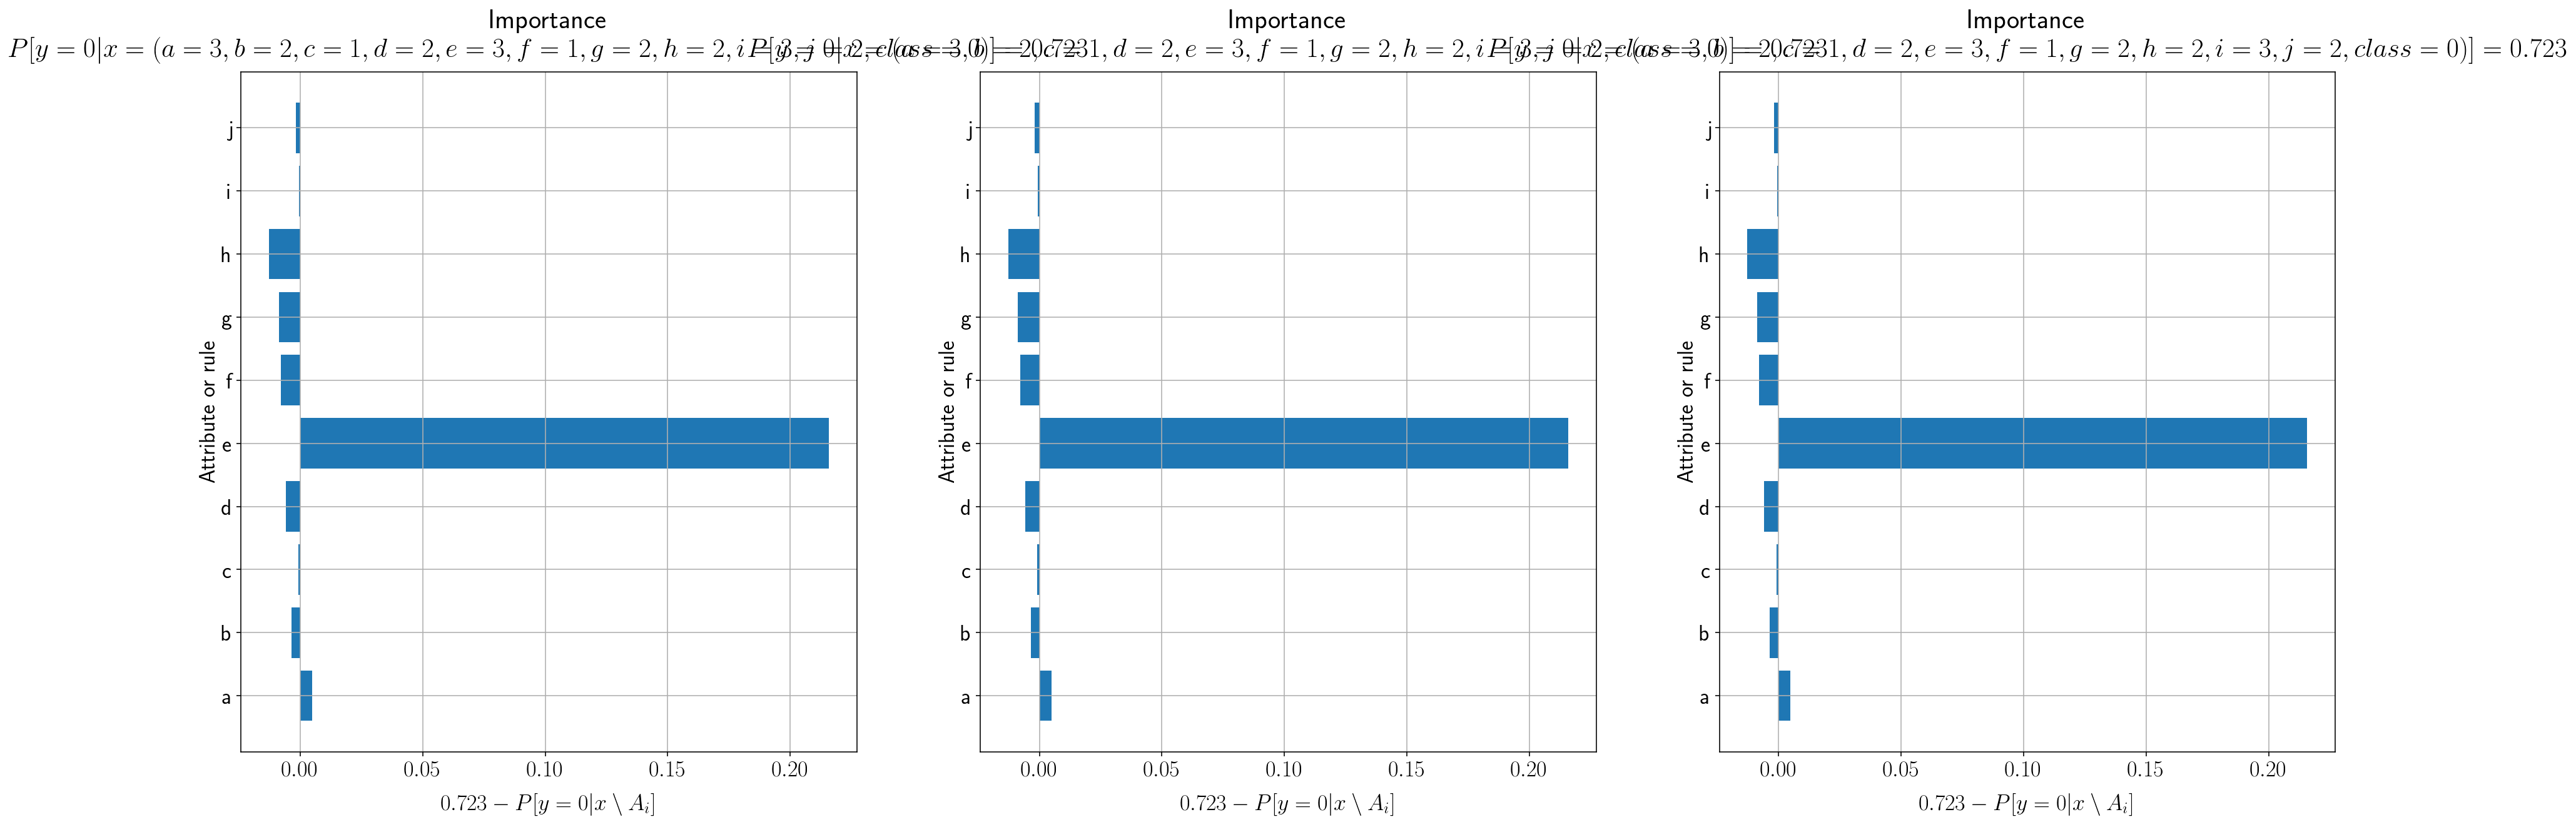

Instance 1
compute_lace_step k=141
explain_instance errors: 8.278E-03
compute_lace_step k=141
explain_instance errors: 8.278E-03
compute_lace_step k=141
explain_instance errors: 8.278E-03


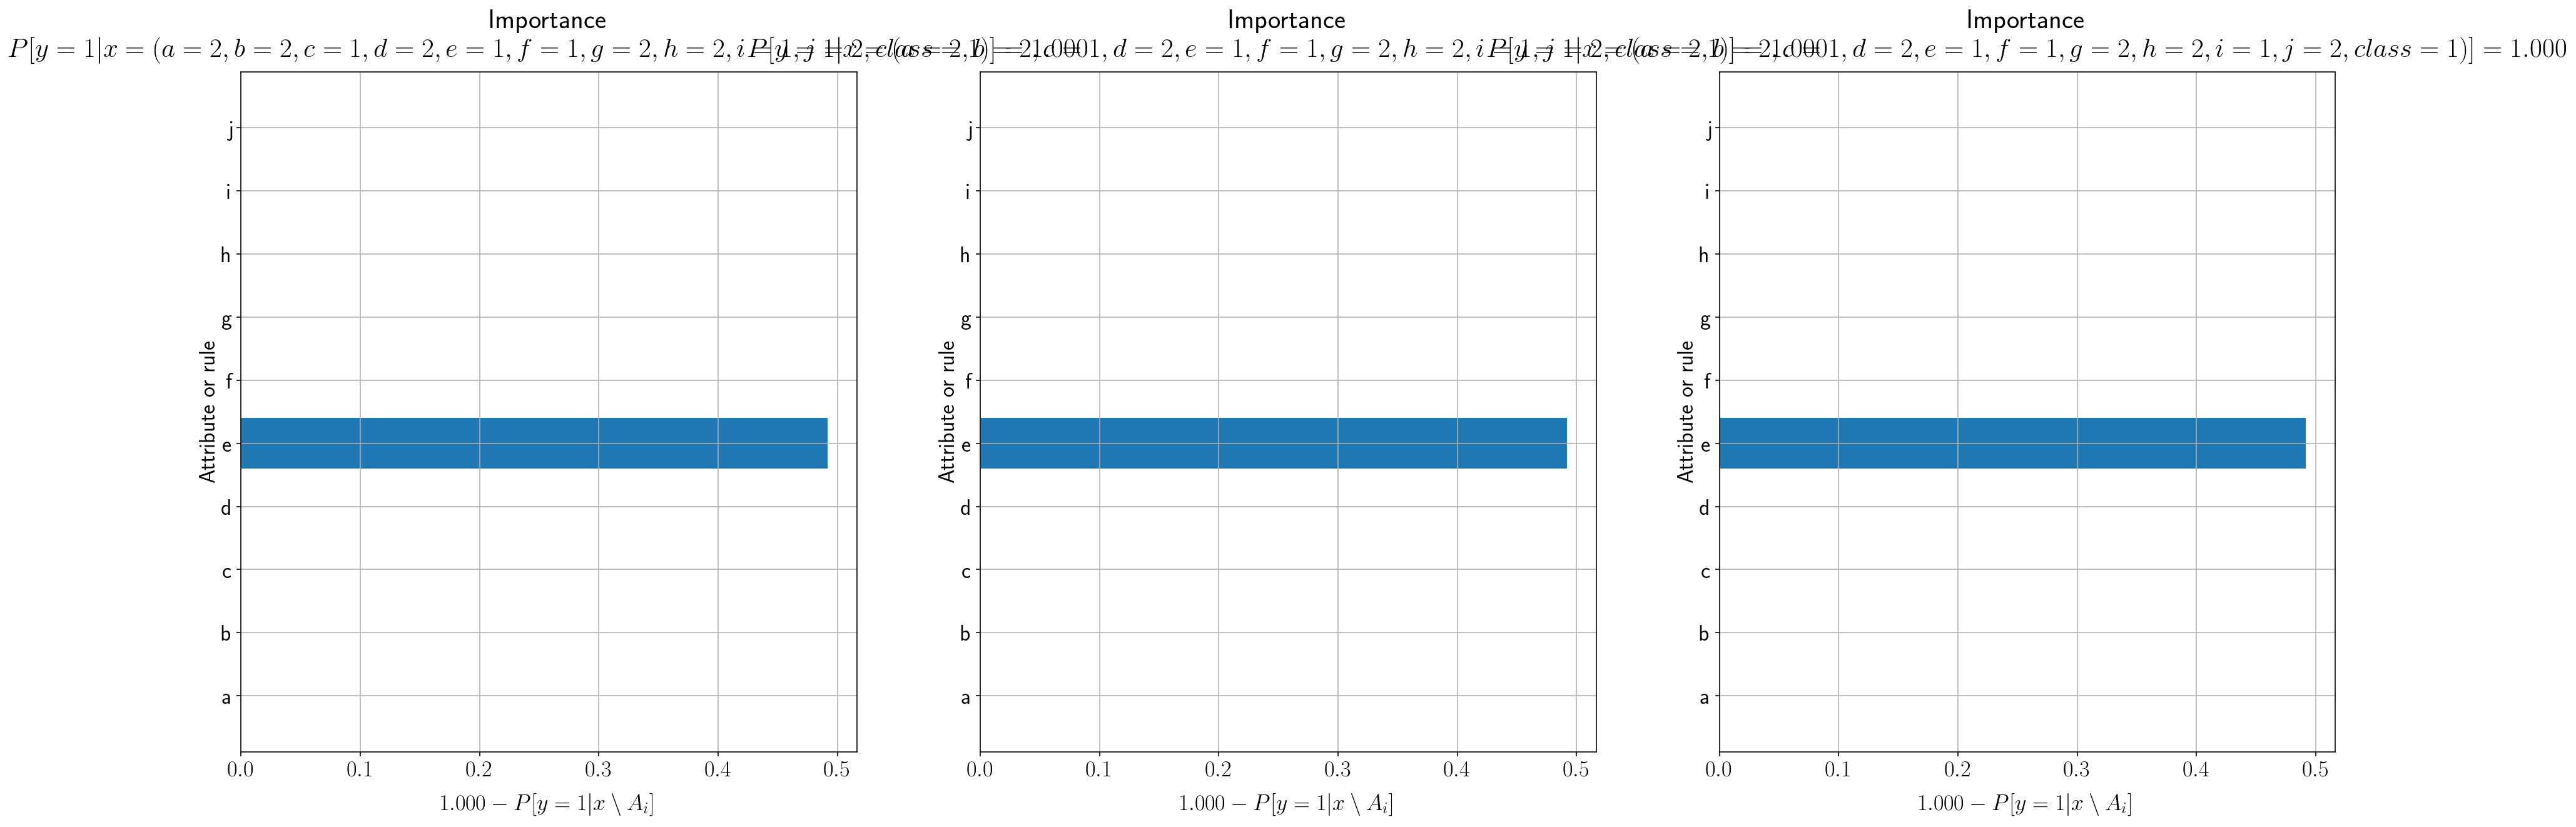

Instance 2
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.216E-01, 2.216E-01, 2.216E-01, 1.130E-02
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.216E-01, 2.216E-01, 2.216E-01, 1.130E-02
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 2.216E-01, 2.216E-01, 2.216E-01, 1.130E-02


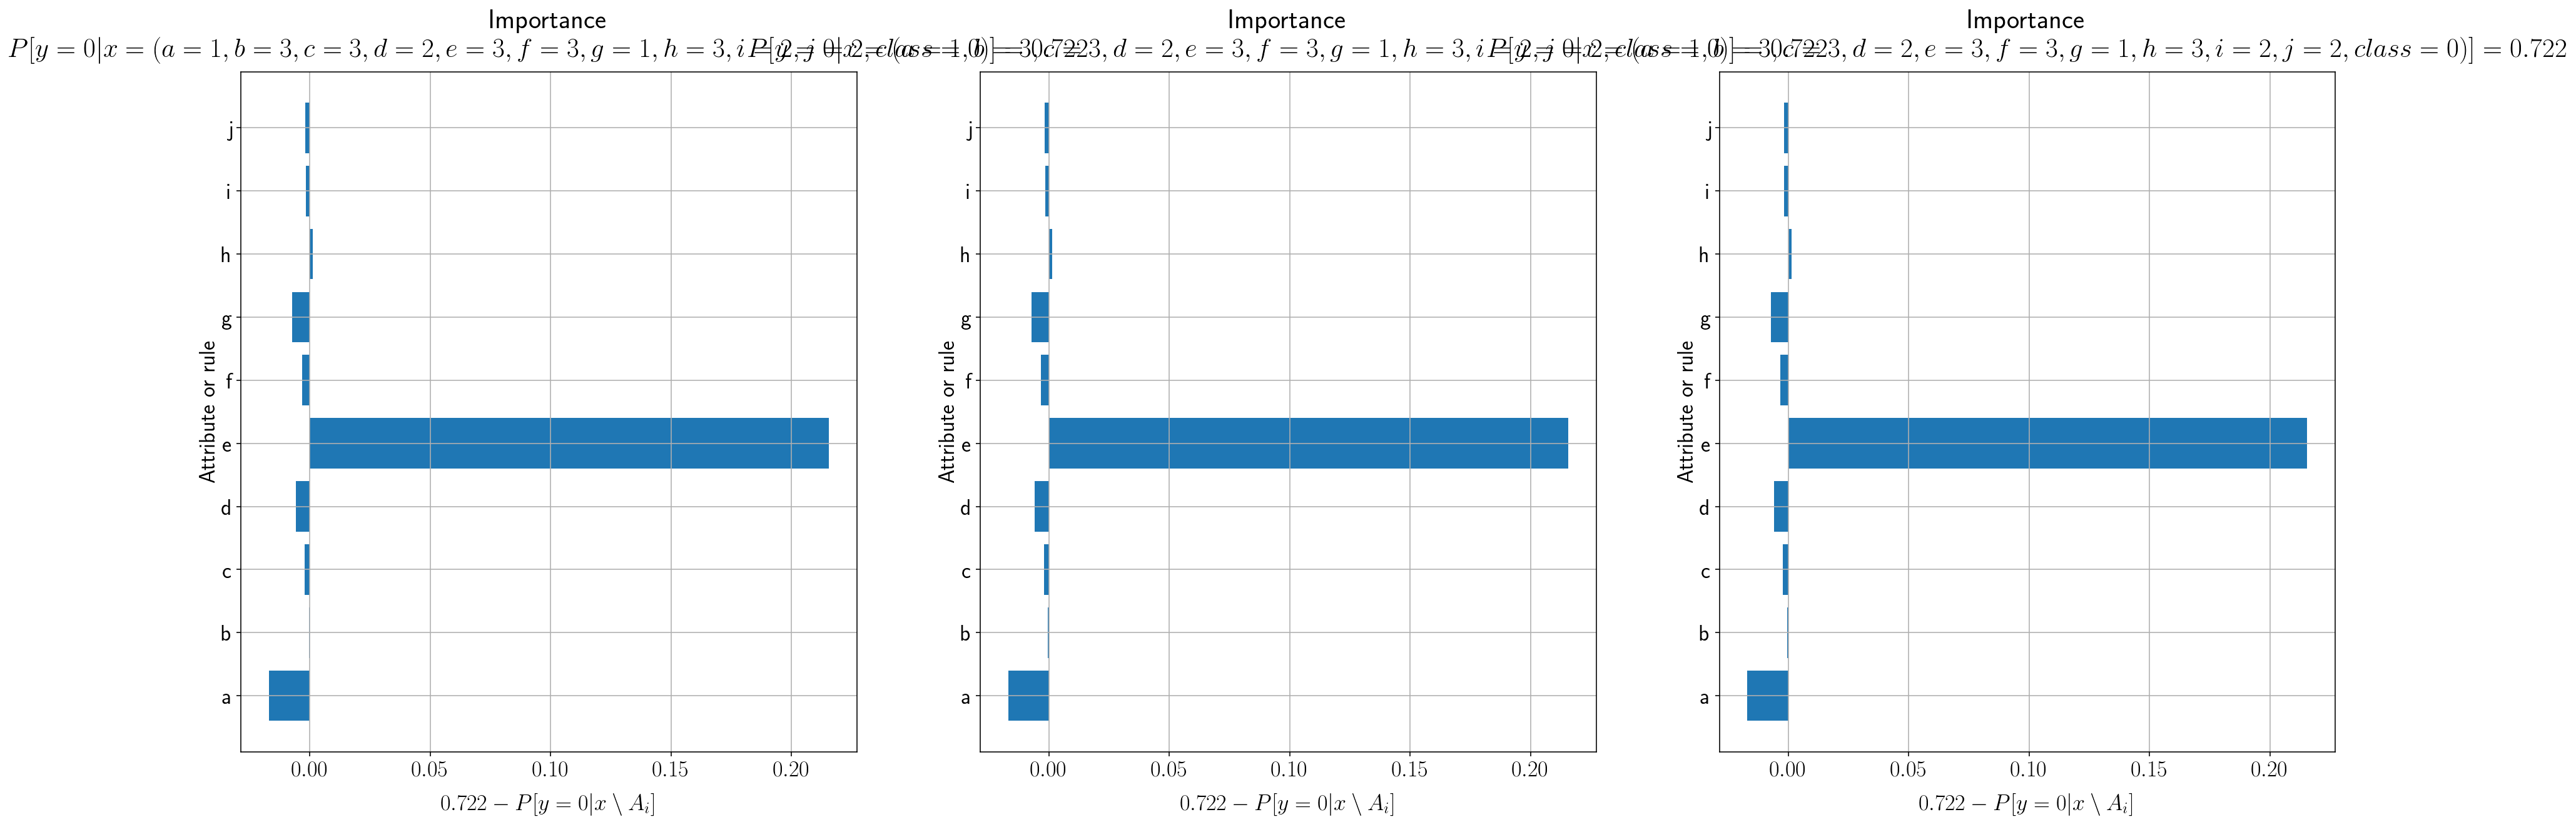

Instance 3
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03


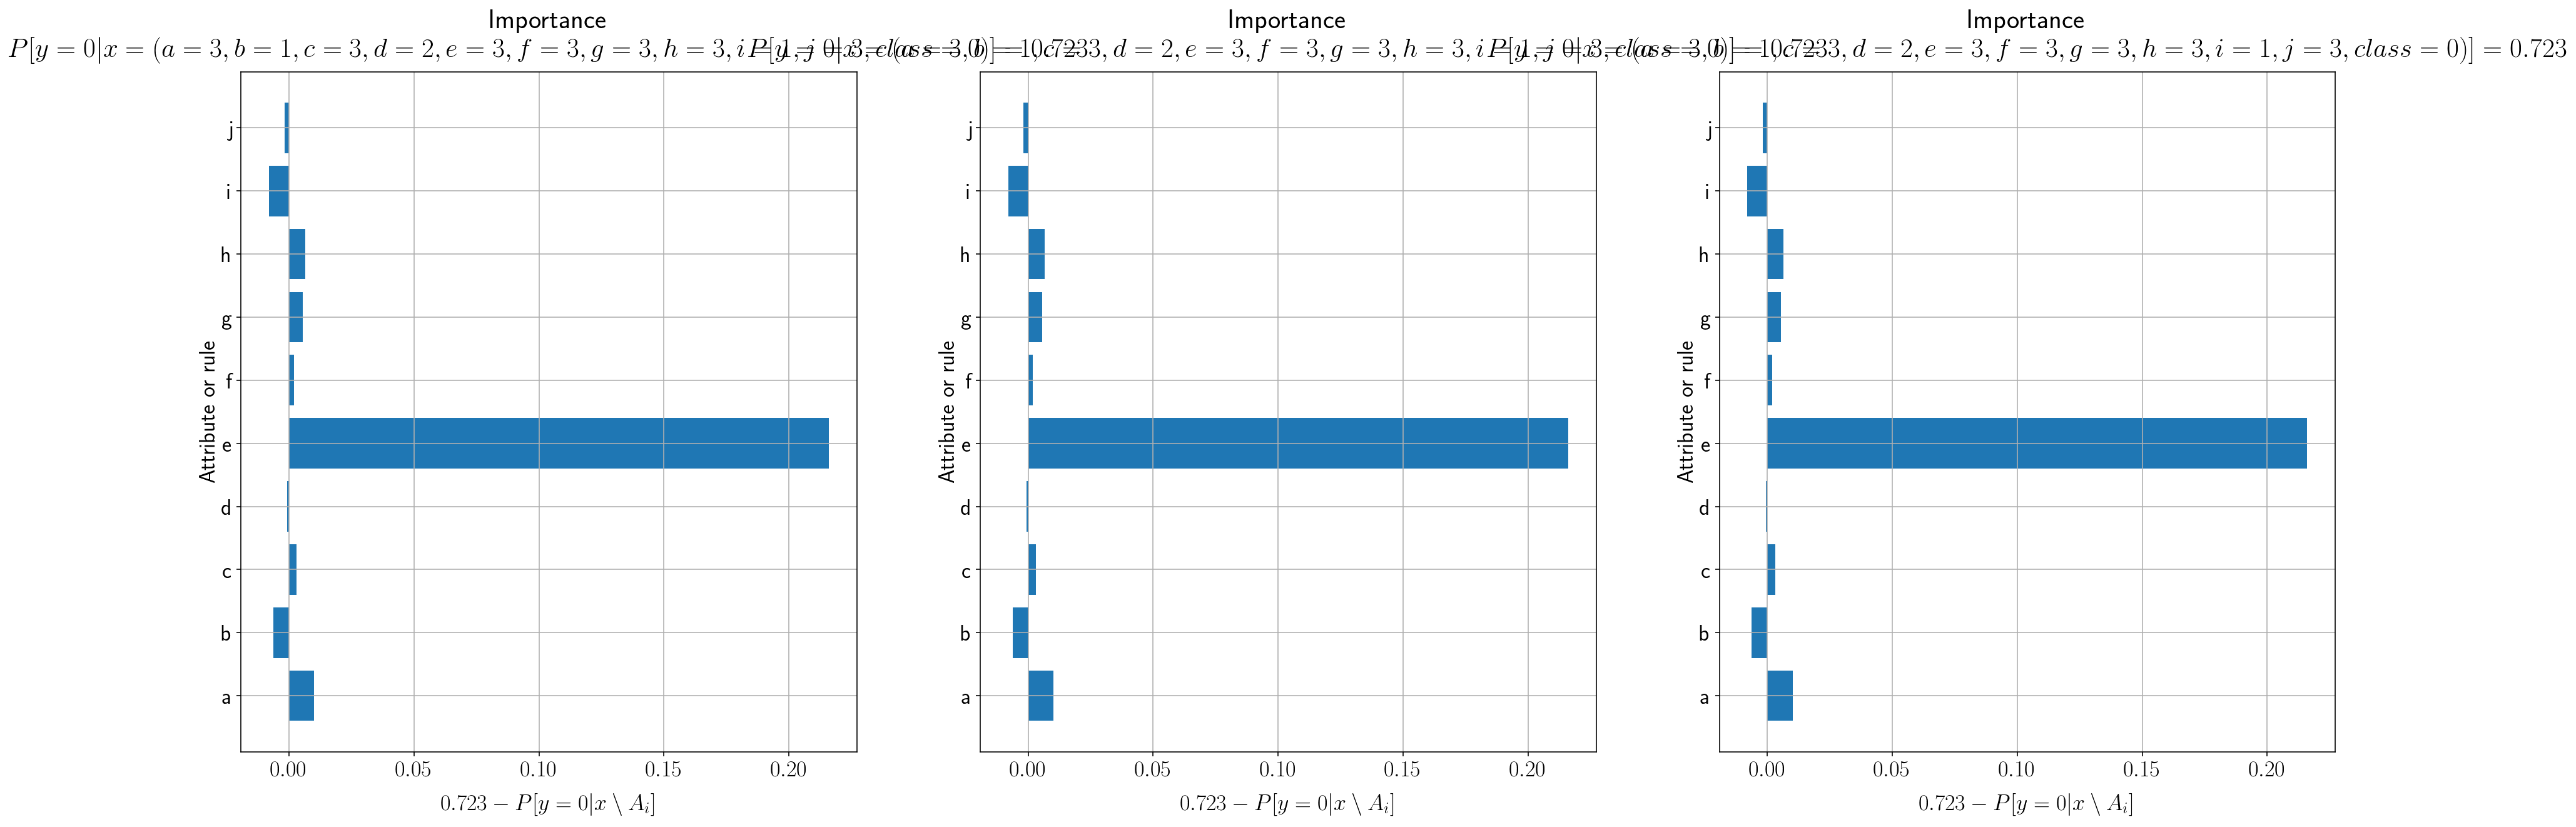

In [17]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Random Forest

Instance 0
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.750E-01, 1.750E-01, 1.750E-01, 6.814E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.750E-01, 1.750E-01, 1.750E-01, 6.814E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.750E-01, 1.750E-01, 1.750E-01, 6.814E-03


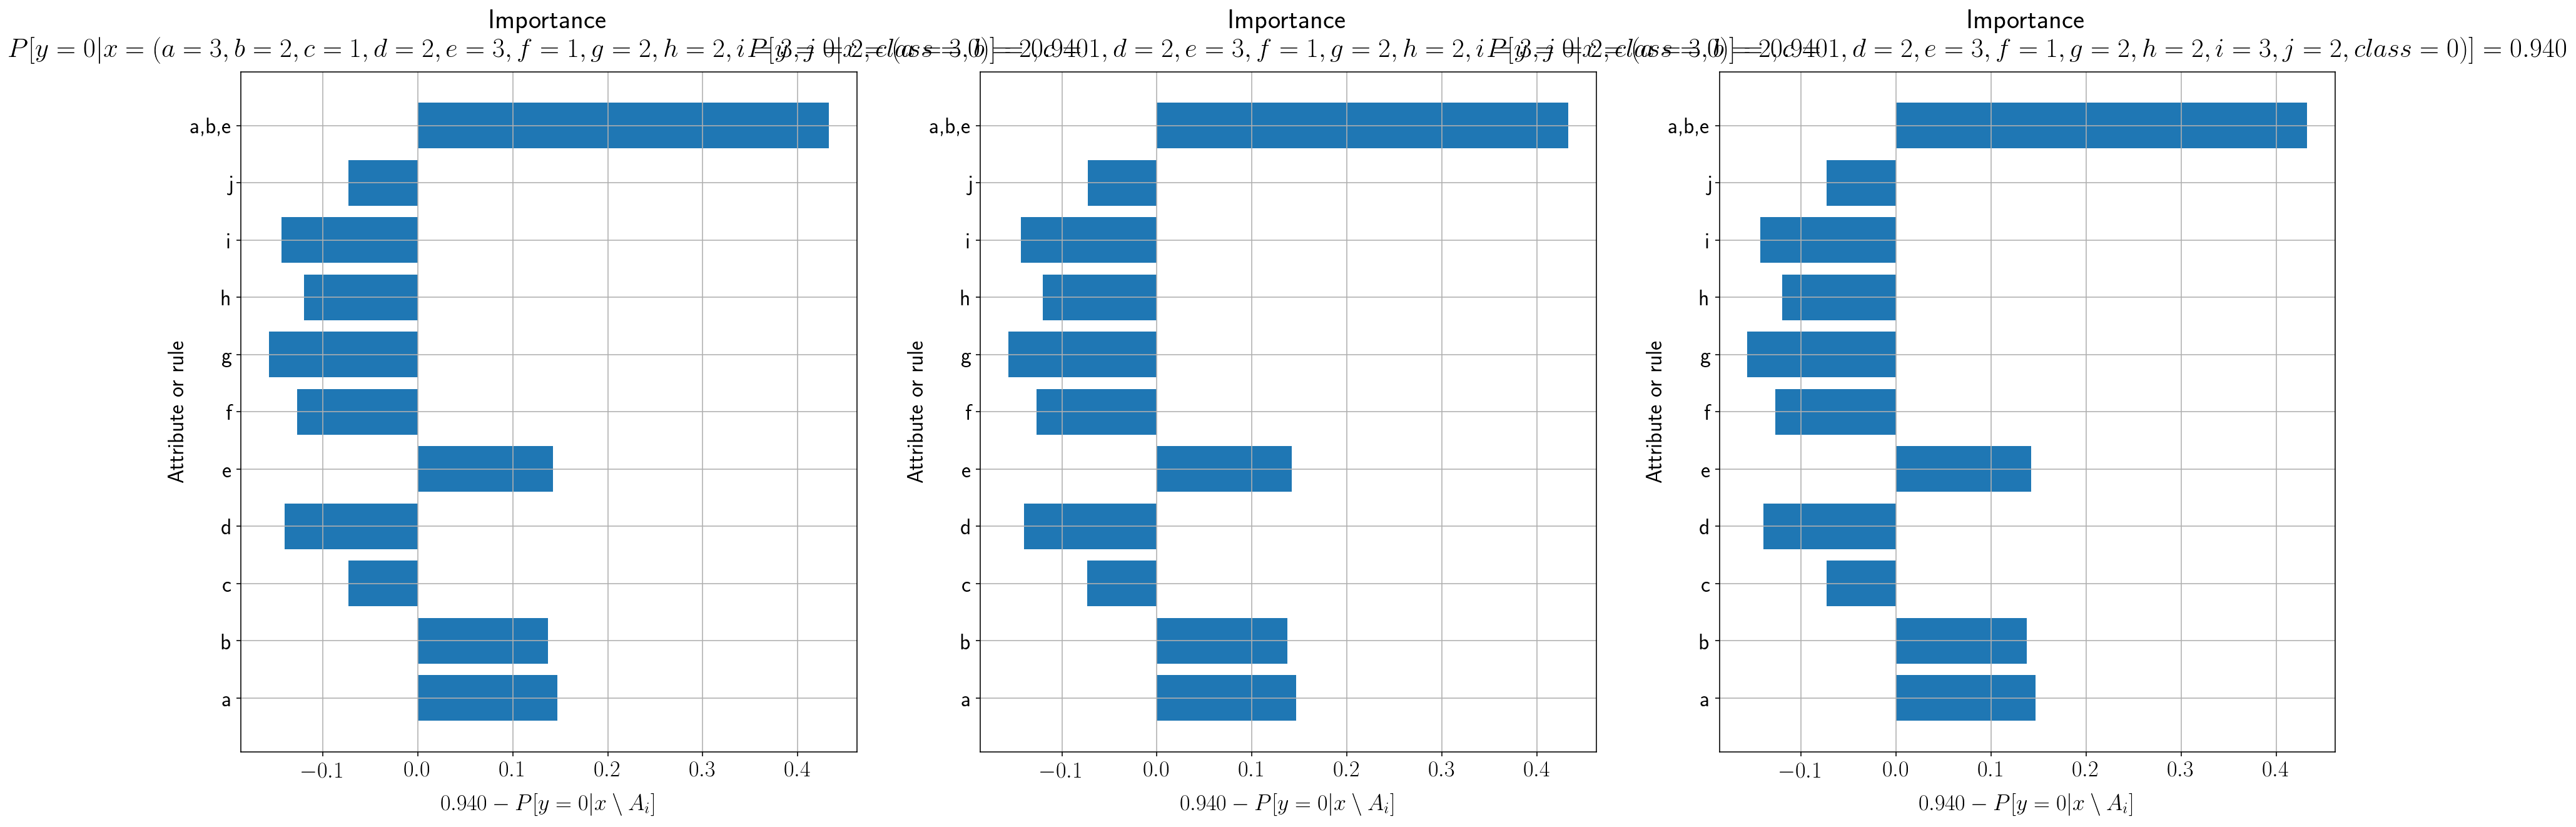

Instance 1
compute_lace_step k=141
explain_instance errors: 1.432E-02
compute_lace_step k=141
explain_instance errors: 1.432E-02
compute_lace_step k=141
explain_instance errors: 1.432E-02


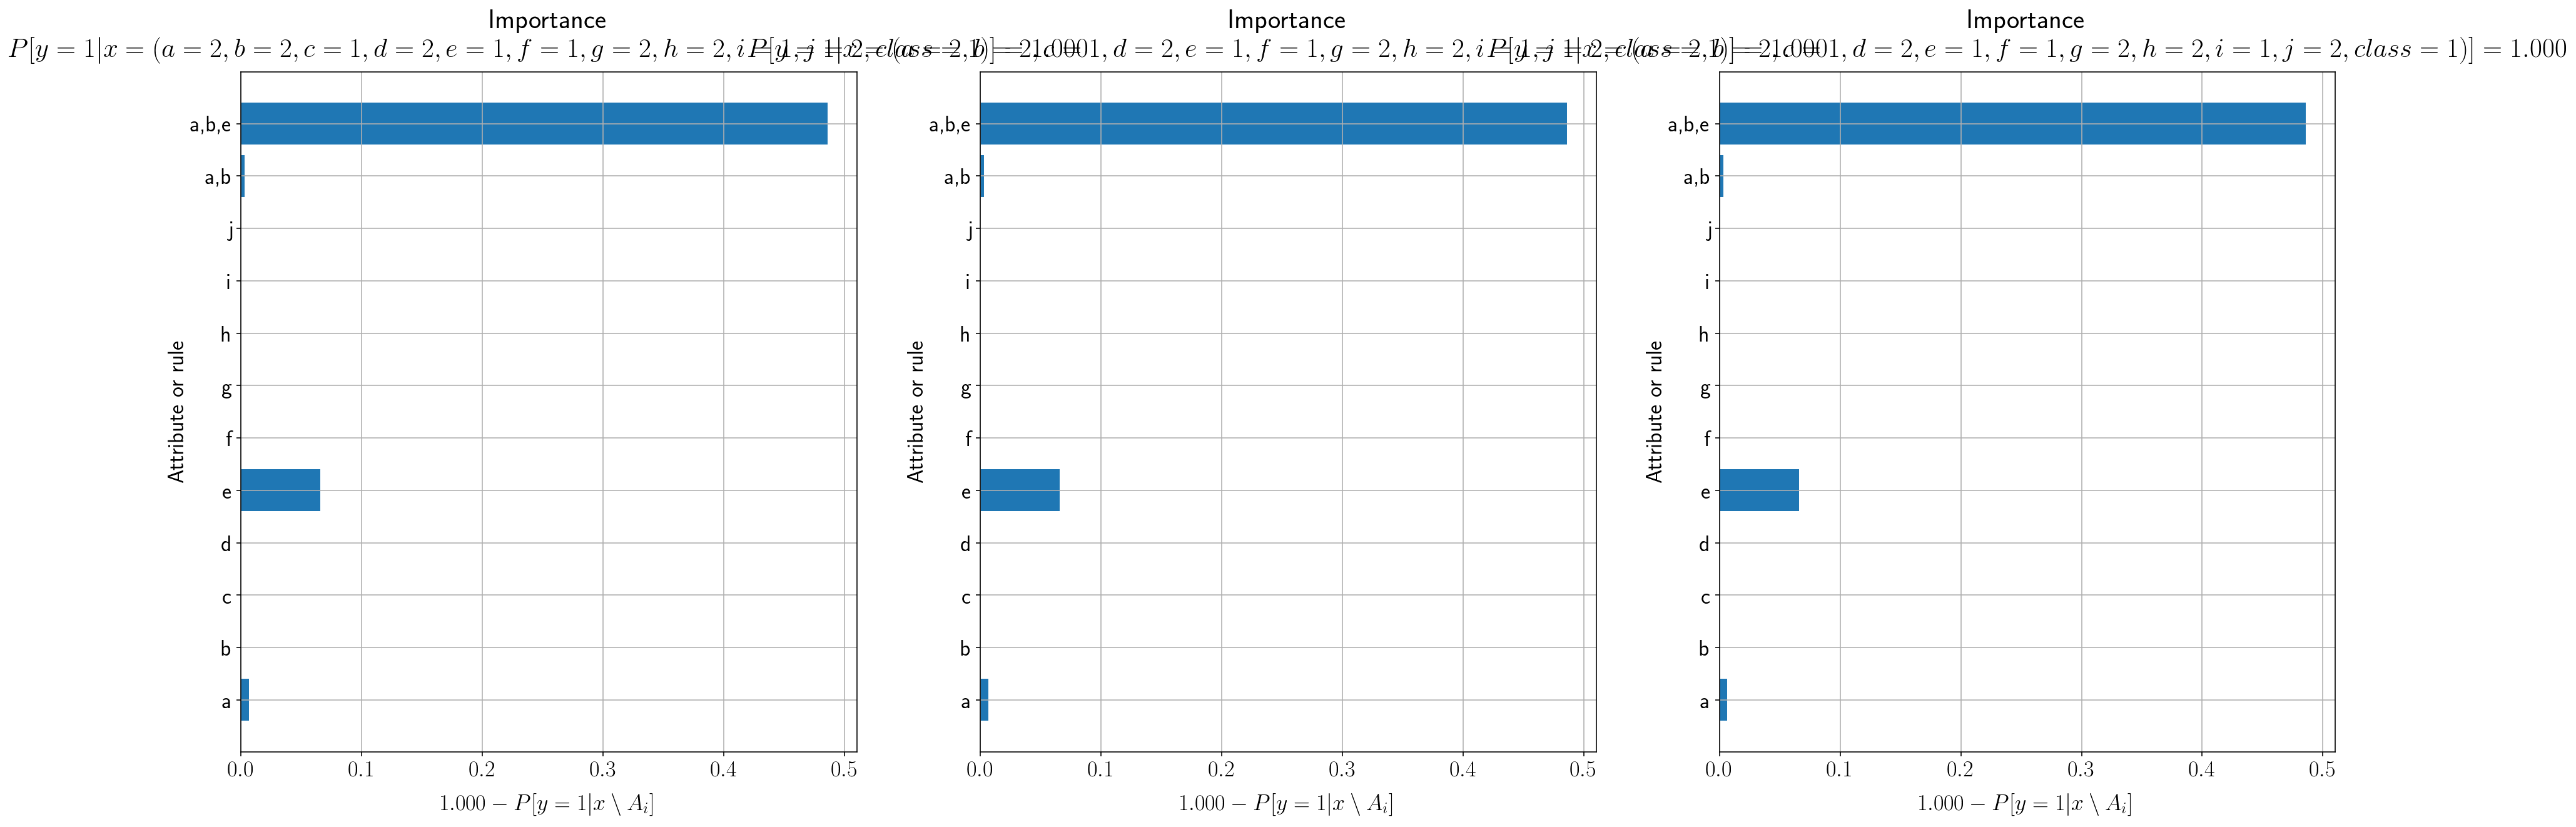

Instance 2
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.555E-01, 2.067E-01
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.555E-01, 2.067E-01
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.555E-01, 2.067E-01


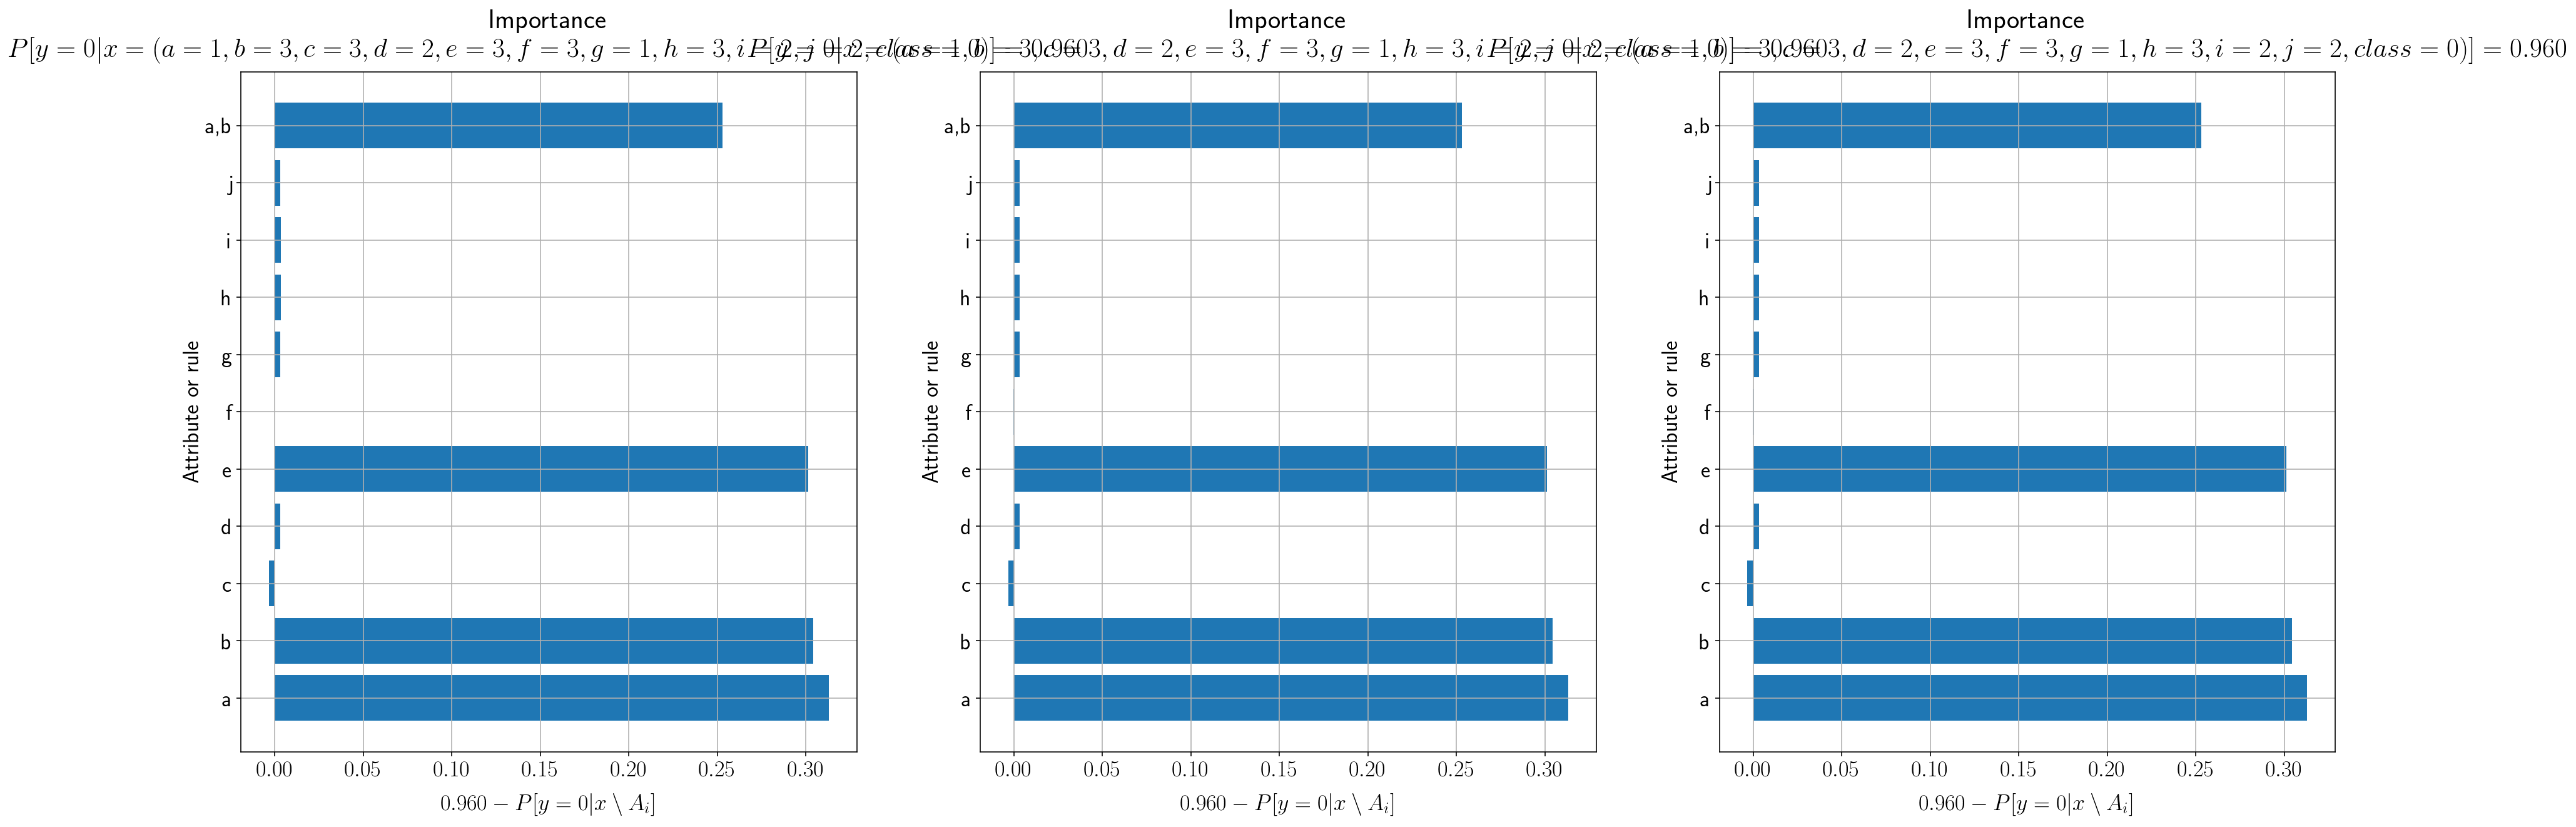

Instance 3
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
compute_lace_step k=705
explain_instance errors: 2.170E-01, 2.815E-02, 2.605E-02, 2.605E-02, 3.328E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
compute_lace_step k=705
explain_instance errors: 2.170E-01, 2.815E-02, 2.605E-02, 2.605E-02, 3.328E-03
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
compute_lace_step k=705
explain_instance errors: 2.170E-01, 2.815E-02, 2.605E-02, 2.605E-02, 3.328E-03


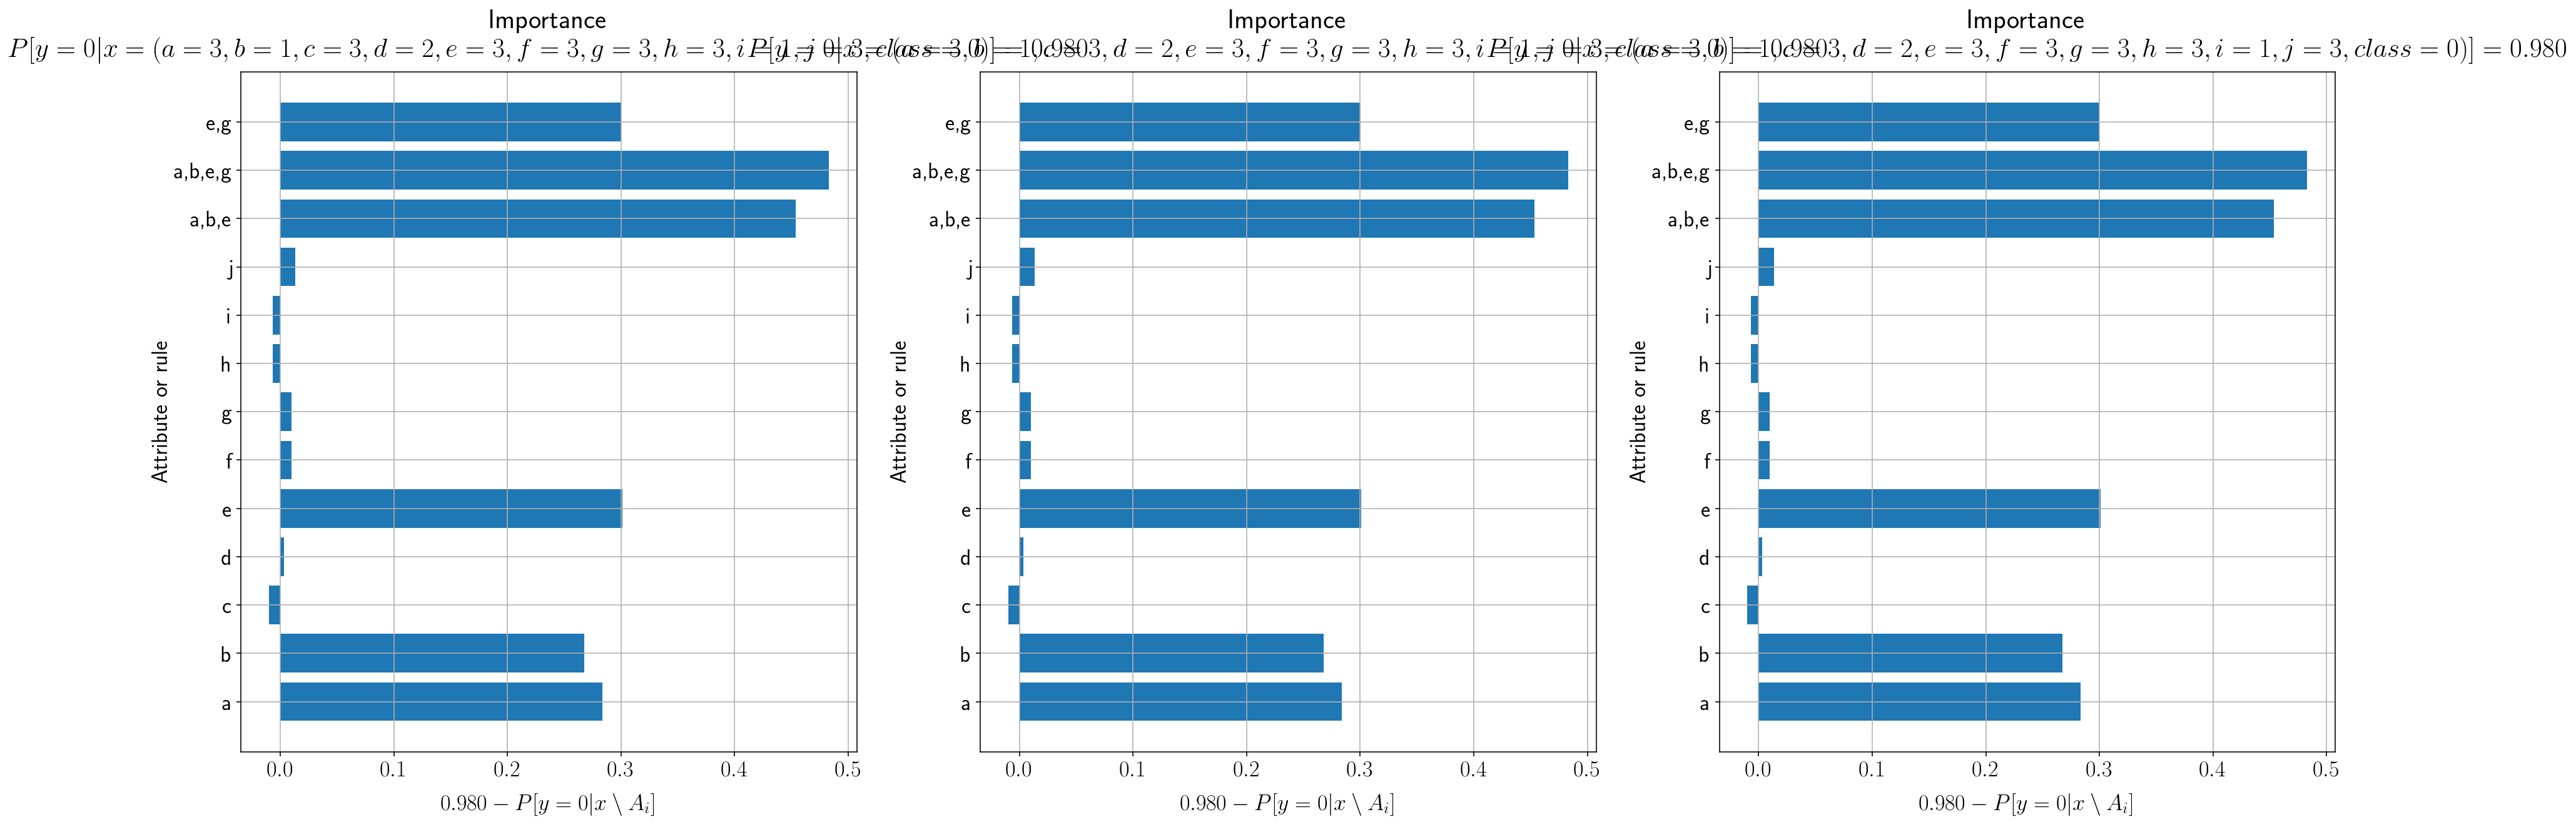

In [18]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Neural Network

Instance 0
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.713E-01, 1.713E-01, 1.713E-01, 3.374E-07
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.713E-01, 1.713E-01, 1.713E-01, 3.374E-07
compute_lace_step k=141
compute_lace_step k=282
compute_lace_step k=423
compute_lace_step k=564
explain_instance errors: 1.713E-01, 1.713E-01, 1.713E-01, 3.374E-07


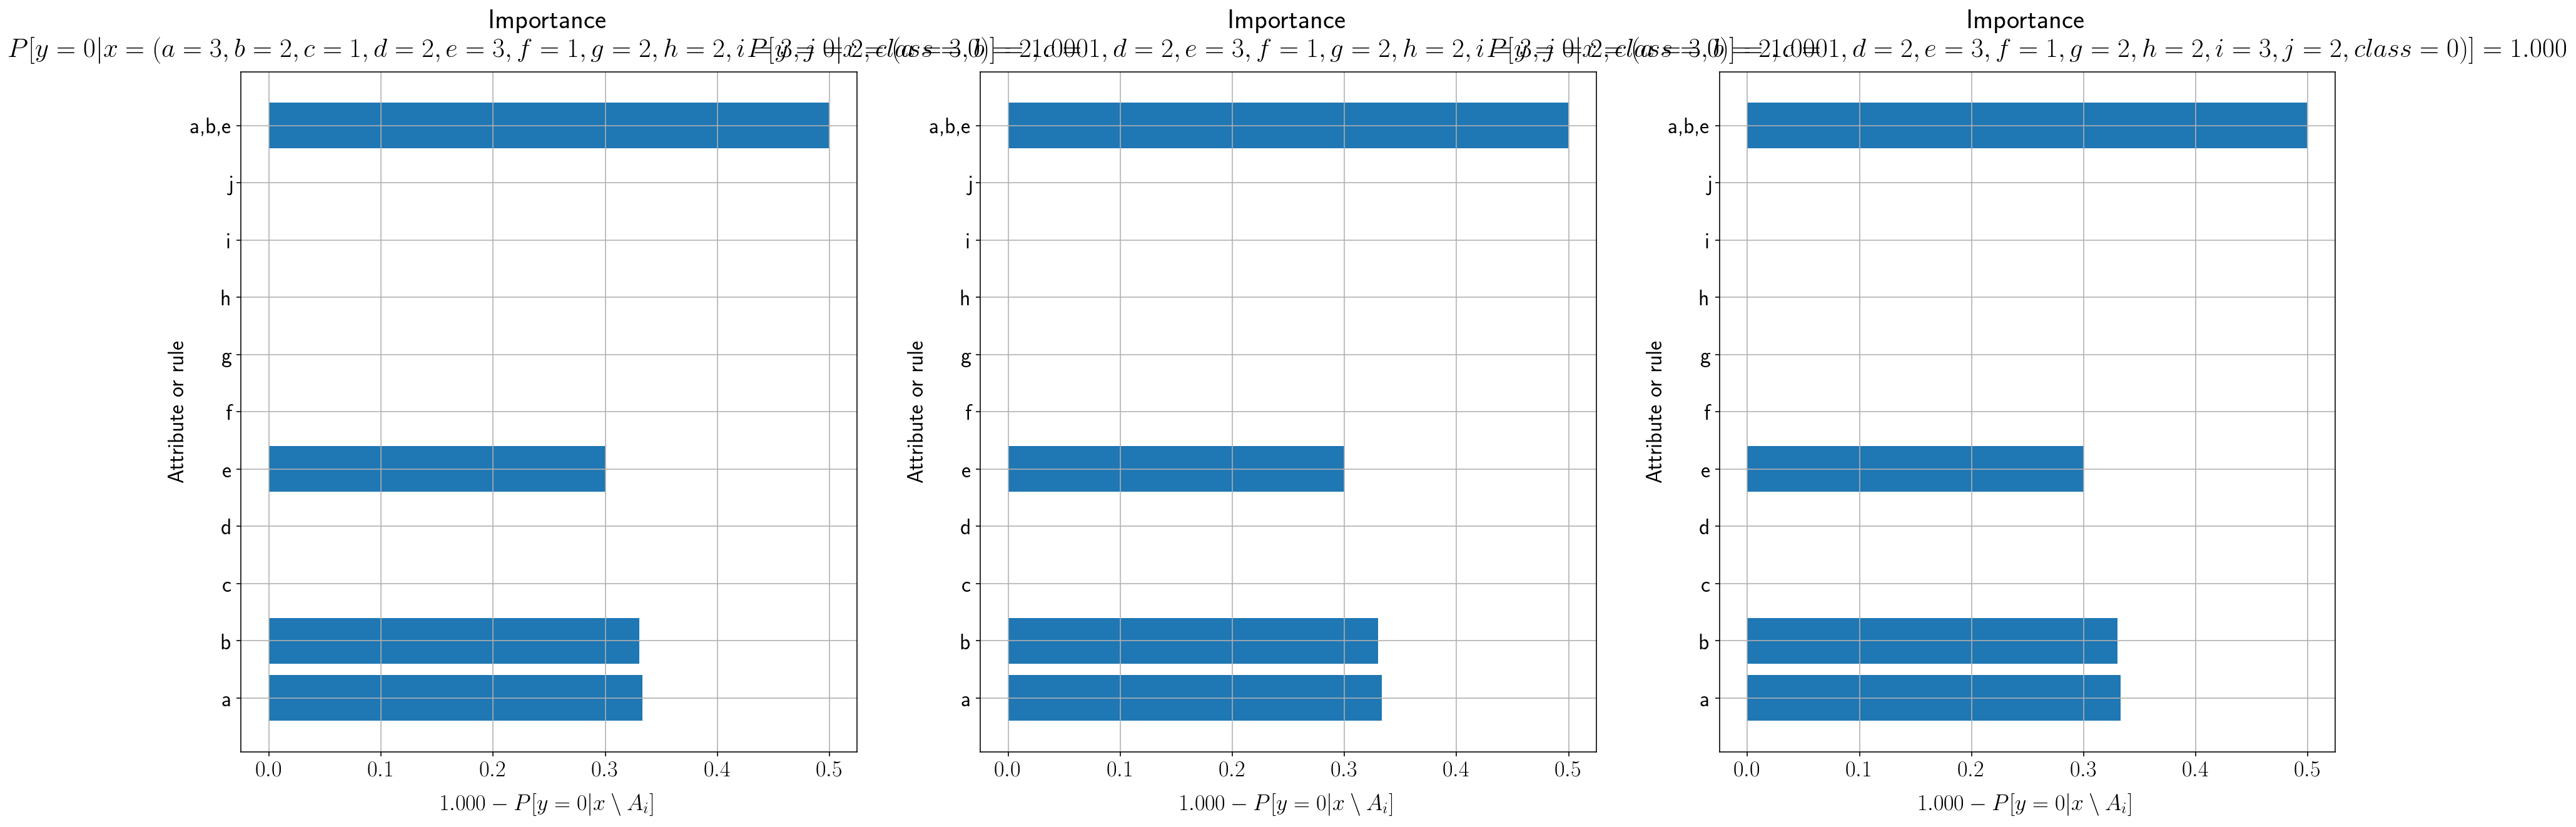

Instance 1
compute_lace_step k=141
explain_instance errors: 5.389E-07
compute_lace_step k=141
explain_instance errors: 5.389E-07
compute_lace_step k=141
explain_instance errors: 5.389E-07


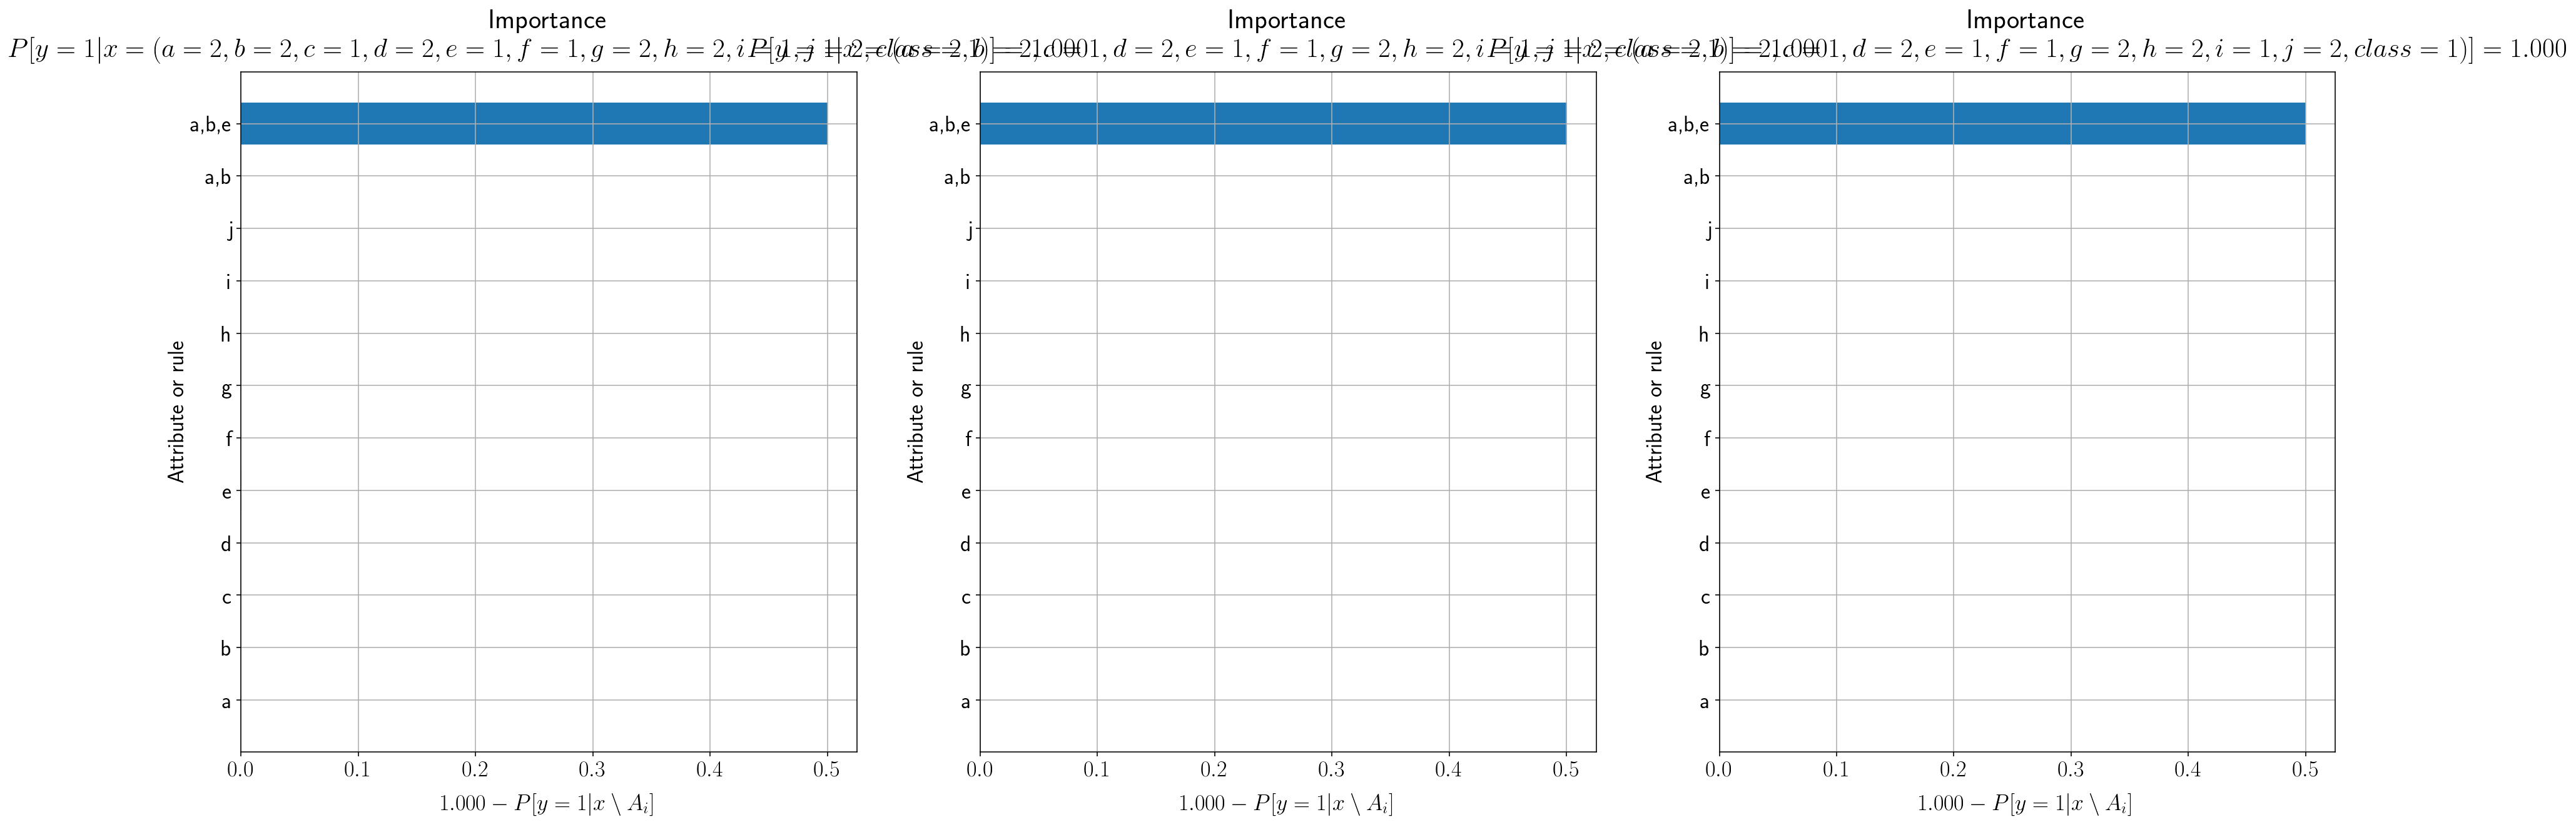

Instance 2
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.610E-01, 1.713E-01
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.610E-01, 1.713E-01
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.610E-01, 1.713E-01


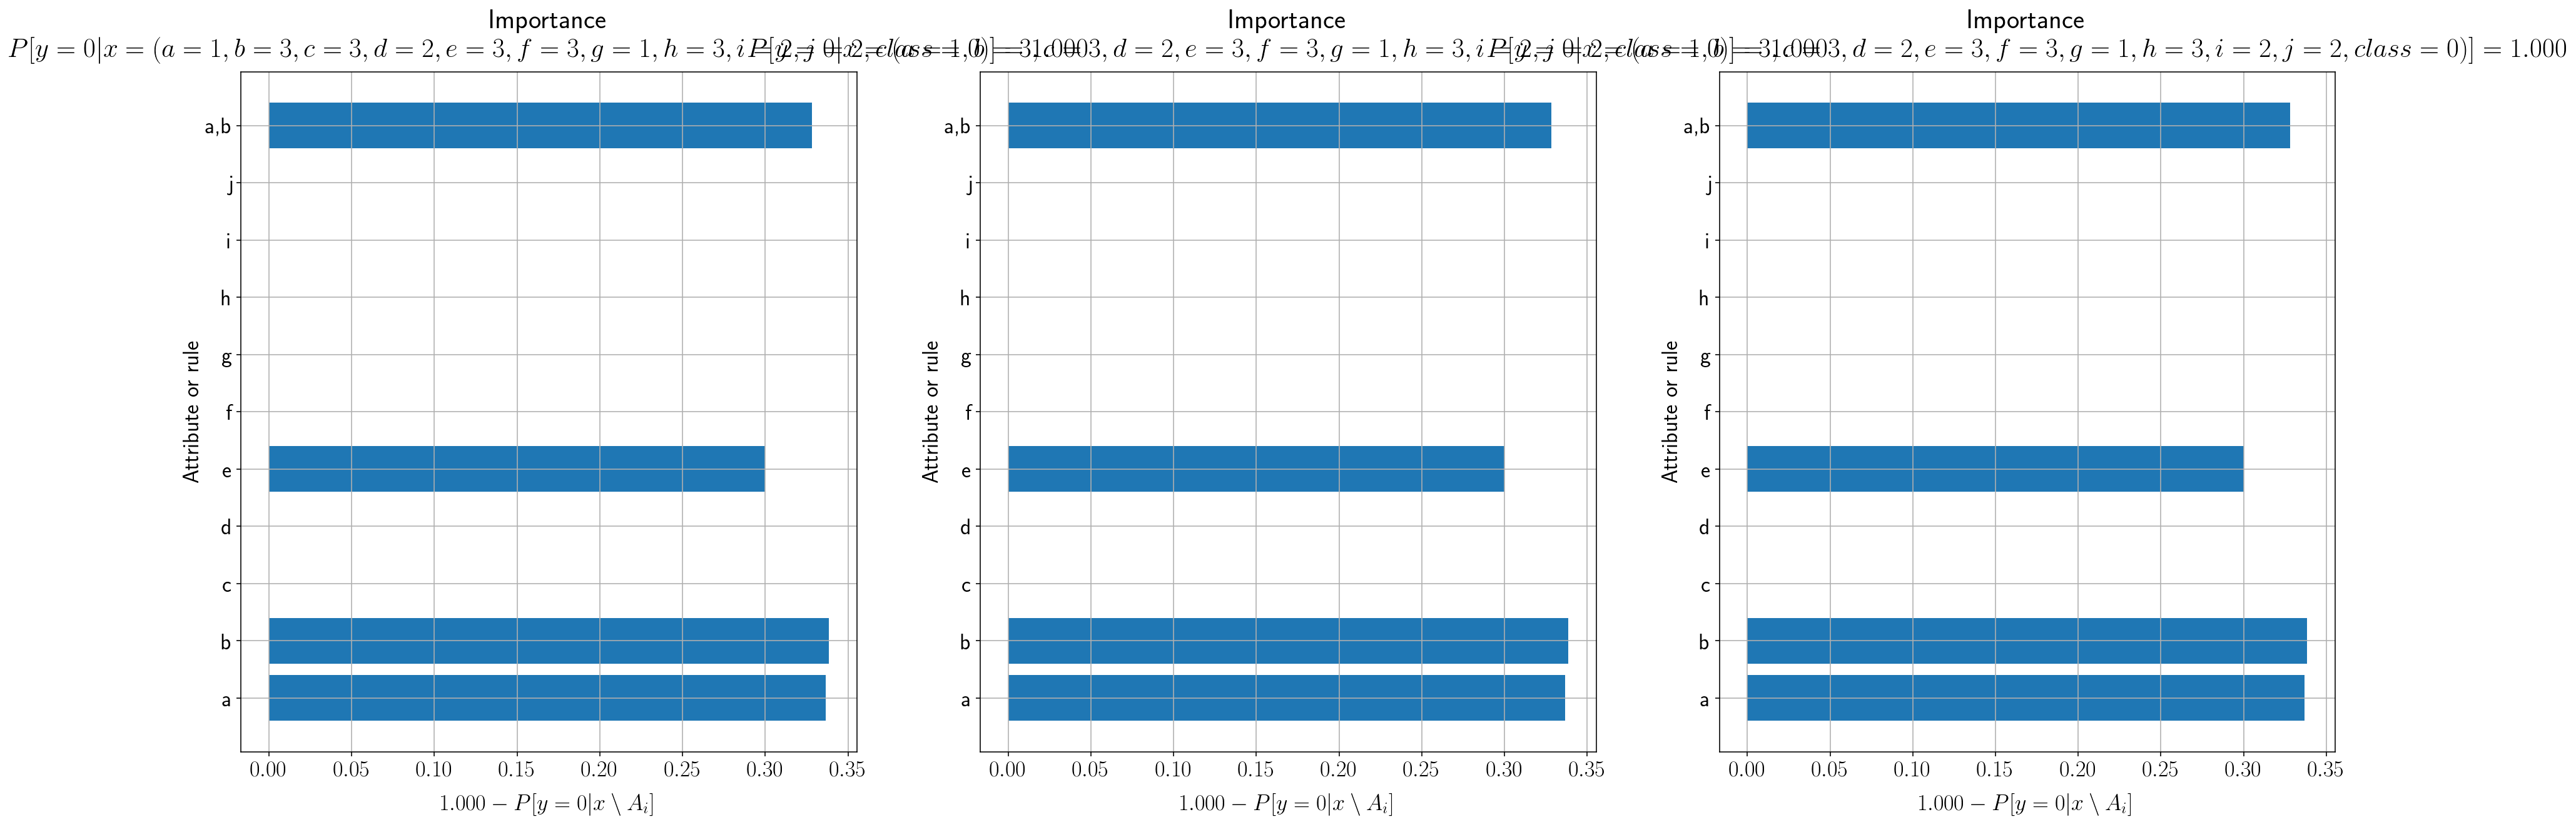

Instance 3
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.713E-01, 2.856E-06
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.713E-01, 2.856E-06
compute_lace_step k=141
compute_lace_step k=282
explain_instance errors: 1.713E-01, 2.856E-06


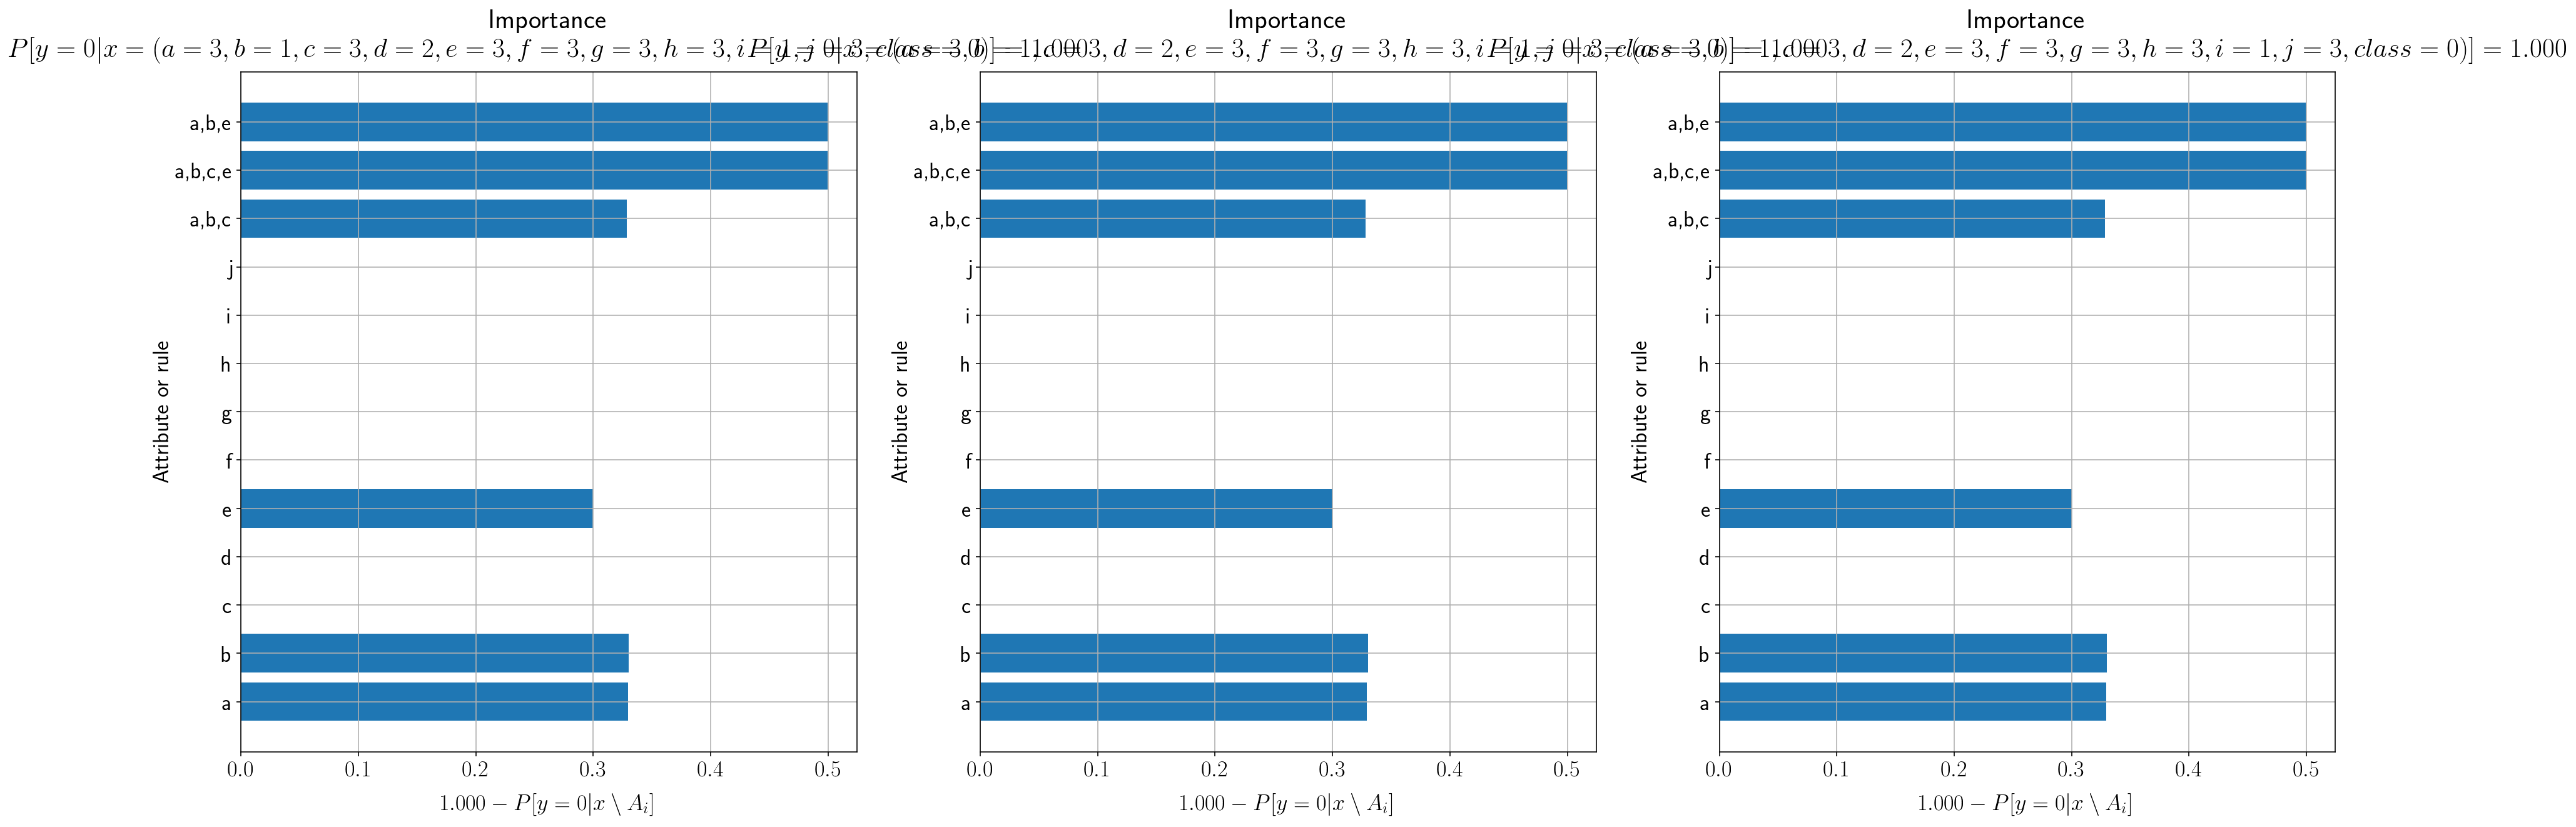

In [19]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.075))
    plt.show()

for i in range(4):
    run(i)